# Comparing Tree Search and Reinforcement Learning Approaches for King and Courtesan Game
## Gloire LINVANI
### CSC-52081-EP Advanced Machine Learning and Autonomous Agents Project

### The following contains adapted material from the labs 6 and 7 developed by Jérémie Decock.

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/refs/heads/main/assets/logo.jpg" style="float: left; width: 15%" />

[CSC-52081-EP-2025](https://moodle.polytechnique.fr/course/view.php?id=19336)

# Colab Environment Setup

#### For practical reasons, we run the notebook in the Google Drive folder where it is located. We need to provide a path.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

# Replace path_to_notebook with your actual path
path_to_notebook = "/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning and Autonomous Agents/Project"

%cd {path_to_notebook}

!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning and Autonomous Agents/Project
/content/drive/MyDrive/Colab Notebooks/Advanced Machine Learning and Autonomous Agents/Project
 build					        KingAndCourtesanEnv.py
 build.gradle				        models
 commons-cli-1.4.jar			       'Peer Review'
'Copy of Reinforcement_Learning_Agents.ipynb'   __pycache__
 example_file_to_read.txt		        qodana.yaml
 example_file_to_write.txt		        README.md
 figs					        Reinforcement_Learning_Agents.ipynb
 gradle					        Reinforcement_Learning_Project_Report.pdf
 gradlew				       'Reinforcement Learning Project Report.zip'
 gradlew.bat				        requirements.txt
 IDAlphaBetaClient.py			        settings.gradle
 json-20250107.jar			        src
 kac_server.log				        test_functions.py
 kac_server.log.1			        Untitled.txt
 KC_2_o.jar


In [ ]:
# Installing Java

!sudo apt update

!sudo apt install default-jdk

!java -version
!javac -version

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,369 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,667 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [64.2 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,533 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.c

### Starting Java servers: Port 3 for King and Courtesan server and port 9 for ID Alpha Beta agent server. You can change the ports if needed

In [ ]:
# Starting the Java server in the background
!nohup java -cp "RL_KAC.jar:json-20250107.jar:commons-cli-1.4.jar" games.kac.RL_Agents_KingAndCourtesanServer -p 3 > server1.log 2>&1 &

In [ ]:
!nohup java -cp "RL_KAC.jar:json-20250107.jar:commons-cli-1.4.jar" games.kac.IDAlphaBetaServer -t 30 -p 9 > server2.log 2>&1 &

In [ ]:
# Giving the server time to start
import time

print("Waiting for server to start...")
time.sleep(5)
!cat server1.log  # Server log
!cat server2.log

Waiting for server to start...
Mar 07, 2025 5:41:37 PM games.kac.RL_Agents_KingAndCourtesanServer main
INFO: King and Courtesan server started on port 3
Mar 07, 2025 5:41:37 PM games.kac.RL_Agents_KingAndCourtesanServer main
INFO: Configuration: boardSize=6, threads=10, clientTimeout=60s, verbose=false
ID Alpha-Beta server started on port 9
Configuration: depth=8, timeLimit=30s


# Requirements

This notebook relies on several libraries like `gymnasium`, `torch`, `numpy`, `tqdm`, `matplotlib`, etc.
A complete list of dependencies can be found in the `requirements.txt` file at the root of the repository

In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

# Imports

In [1]:
import collections
from importlib import reload

import gymnasium as gym
import math
import itertools
import numpy as np

import pandas as pd
from pathlib import Path
import random
import torch
from typing import Union, List, Tuple, Optional, Callable

import test_functions
import KingAndCourtesanEnv as kac
import joblib
from importlib import reload

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

import seaborn as sns
from tqdm.notebook import tqdm

In [3]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
sns.set_context("talk")

In [5]:
PLOTS_DIR = Path("figs/") / "RL Agents"  # Where to save plots (.png or .svg files)
MODELS_DIR = Path("models/") / "RL Agents"  # Where to save models (.pth files)

In [6]:
if not PLOTS_DIR.exists():
    PLOTS_DIR.mkdir(parents=True)
if not MODELS_DIR.exists():
    MODELS_DIR.mkdir(parents=True)

In [7]:
DEFAULT_NUMBER_OF_TRAININGS = 3
BOARD_SIZE = 6

## PyTorch setup

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Set the device to CUDA if available, otherwise use CPU

In [9]:
print("Available GPUs:")
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"- Device {i}: {torch.cuda.get_device_name(i)}")
elif torch.backends.mps.is_available():
    print("Using Metal Performance Shaders (MPS)")
    print(f"{torch.mps.device_count()} GPU(s) available.")
else:
    print("- No GPU available.")

Available GPUs:
Using Metal Performance Shaders (MPS)
1 GPU(s) available.


In [10]:
print(f"PyTorch will train and test neural networks on {device}")

PyTorch will train and test neural networks on mps


## 1. Python King And Courtesan Environment Wrapper

#### The environement and ID Alpha Beta client are implemented in modules `KingAndCourtesanEnv.py` and `IDAlphaBetaClient.py`

Print some information about the environment:

In [ ]:
env = kac.KingAndCourtesanEnv(host='localhost', port=3, render_mode='human')

# Use environment for training/testing
state, info = env.reset()
print(f"Available legal moves: {info['legal_moves']}")

# For rendering
env.render()

# Close when done
env.close()

Connected to Java server at localhost:3
Available legal moves: ['A0-A1', 'A0-B0', 'A0-B1', 'A3-B4', 'A4-A5', 'A4-B4', 'A4-B5', 'B2-C3', 'B3-B4', 'B3-C3', 'B3-C4', 'C1-D2', 'C2-C3', 'C2-D2', 'C2-D3', 'D0-E1', 'D1-D2', 'D1-E1', 'D1-E2', 'E0-E1', 'E0-F0', 'E0-F1']
  012345
F -BBBBQ
E R-BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Connection to Java server closed


In [ ]:
info

{'legal_moves': ['A0-A1',
  'A0-B0',
  'A0-B1',
  'A3-B4',
  'A4-A5',
  'A4-B4',
  'A4-B5',
  'B2-C3',
  'B3-B4',
  'B3-C3',
  'B3-C4',
  'C1-D2',
  'C2-C3',
  'C2-D2',
  'C2-D3',
  'D0-E1',
  'D1-D2',
  'D1-E1',
  'D1-E2',
  'E0-E1',
  'E0-F0',
  'E0-F1'],
 'is_first_player': True,
 'current_player_role': 'RED'}

#### Testing the environment with two random policies

In [ ]:
env = kac.KingAndCourtesanEnv(host='localhost', port=3, render_mode='human')

_, _ = env.reset()

for t in range(50):
    print("step", t)
    action = env.sample_legal_action()
    observation, reward, done, truncated, info = env.step(action)
    env.render()
    if done:
        print("Game Over")
        break
env.close()

Connected to Java server at localhost:3
step 0
  012345
F -BBBBQ
E R-BBBB
D RRRBBB
C RR--BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 1
  012345
F -BBBBQ
E R-BBBB
D RRRB-B
C RR-BBB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 2
  012345
F -BBBBQ
E R-RBBB
D R-RB-B
C RR-BBB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 3
  012345
F -B-BBQ
E RBRBBB
D R-RB-B
C RR-BBB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 4
  012345
F -B-RBQ
E RB-BBB
D R-RB-B
C RR-BBB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
step 5
  012345
F -B-RQB
E RB-BBB
D R-RB-B
C RR-BBB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position: (0,0)
step 6
  012345
F -B-RQB
E RB-BBB
D R-RB-B
C RR-RBB
B RRR--B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position: (0,0)
step 7
  012345
F -B-RQB
E B--BBB
D R-RB-B
C RR-RBB
B RRR--B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position

### Testing a random agent against ID Alpha-Beta agent

In [ ]:
result = test_functions.test_random_vs_alphabeta(
    env_port=3,
    agent_port=9,
    render_mode='human',
    delay_between_moves=1.0,
    response_timeout=50,
)

print("\nGame Results:")
print(f"Winner: {result['winner']}")
print(f"Steps: {result['steps']}")
print(f"Random played as: {result['random_player_role']}")
print(f"Alpha-Beta played as: {result['alphabeta_player_role']}")

Connected to Java server at localhost:3
Connection attempt 1/3 failed: [Errno 111] Connection refused
Retrying in 2 seconds...
Connection attempt 2/3 failed: [Errno 111] Connection refused
Retrying in 2 seconds...
Connection attempt 3/3 failed: [Errno 111] Connection refused
All connection attempts failed - will use random legal moves instead
Random agent plays first (RED)
ID Alpha-Beta agent plays second (BLUE)
Move 0
Random agent's turn
  012345
F -BBBBQ
E R-BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRR-R
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 1
ID Alpha-Beta agent's turn
Error during game: ID Alpha-Beta agent is not connected to the server
Connection to Java server closed

Game Results:
Winner: None
Steps: 1
Random played as: RED
Alpha-Beta played as: BLUE


## 2. Deep value-based Reinforcement Learning with Deep Q-Networks (DQN)
## Deep Q-Networks v2 (DQN version 2015) with infrequent weight updates

## 2.1. The Q-network

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class QNetwork(nn.Module):
    """Q-Network for King and Courtesan game."""

    def __init__(self, board_size=6, action_space_size=None):
        super(QNetwork, self).__init__()

        # Input: 6 channels representing the board state
        self.board_size = board_size
        if action_space_size is None:
            self.action_space_size = board_size * board_size * board_size * board_size
        else:
            self.action_space_size = action_space_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Calculate the size after convolutions
        conv_output_size = 128 * board_size * board_size

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.action_space_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Convolutional layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer (no activation, as we want raw Q-values)
        x = self.fc3(x)

        return x

    def get_params(self) -> np.ndarray:
        """
        Get the parameters.

        Returns
        -------
        np.ndarray
            The parameters of the model.
        """
        return self.params.copy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the parameters.

        Parameters
        ----------
        params : np.ndarray
            The parameters of the model.
        """
        self.params = params.copy()

### 2.1.1 Inference Function

#### Testing on the untrained agent against itself

In [ ]:
render_mode = 'human'
num_episodes = 1

In [ ]:
# Initialize Q-Networks
q_network = QNetwork(board_size=BOARD_SIZE).to(device)
q_network_adversary = QNetwork(board_size=BOARD_SIZE).to(device)

print(f"Starting Q-Network vs Q-Network test...")
print(f"Board size: {BOARD_SIZE}x{BOARD_SIZE}")

# Run test
stats = test_functions.test_q_network_agent(
    env_port=9,
    q_network=q_network,
    q_network_adversary=q_network_adversary,
    num_episode=num_episodes,
    render=(render_mode == 'human'),
)

print("\nGame Results:")
print(f"Winner: {stats['winner']}")
print(f"Steps: {stats['steps']}")
print(f"Main Network played as: {stats['main_network_role']}")
print(f"Adversary Network played as: {stats['adversary_role']}")

Connected to Java server at localhost:3
Starting Q-Network vs Q-Network test...
Board size: 6x6
Adversary plays first (RED)
Main agent plays second (BLUE)
Move 1, Player: RED
Selected move: E0-F1
  012345
F -RBBBQ
E --BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 2, Player: BLUE
Selected move: F2-F1
  012345
F -B-BBQ
E --BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 3, Player: RED
Selected move: B2-C3
  012345
F -B-BBQ
E --BBBB
D RR-BBB
C RRRRBB
B RR-R-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 4, Player: BLUE
Selected move: D3-C3
  012345
F -B-BBQ
E --BBBB
D RR--BB
C RRRBBB
B RR-R-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 5, Player: RED
Selected move: A2-B2
  012345
F -B-BBQ
E --BBBB
D RR--BB
C RRRBBB
B RRRR-B
A KR-RR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 6, Player: BLUE
Selected move: B5-A4
  012345
F -B-BBQ
E --BBBB

#### Testing the untrained agent against random agent

In [ ]:
q_network = QNetwork(board_size=BOARD_SIZE).to(device)
results = test_functions.test_q_network_vs_random(env_port=3, num_episodes=5, q_network=q_network)

Connected to Java server at localhost:3

Episode 1/5
Q-Network plays second (BLUE)
Random agent plays first (RED)

Move 1
Player: Random (RED)
Selected move: A0-B0
  012345
F -BBBBQ
E R-BBBB
D RR-BBB
C RRR-BB
B KRRR-B
A RRRRR-
BLUE KING Position: (5,5)
RED KING Position: (1,0)

Move 2
Player: Q-Network (BLUE)
Selected move: B5-A5
  012345
F -BBBBQ
E R-BBBB
D RR-BBB
C RRR-BB
B KRRR--
A RRRRRB
BLUE KING Position: (5,5)
RED KING Position: (1,0)

Move 3
Player: Random (RED)
Selected move: B3-C3
  012345
F -BBBBQ
E R-BBBB
D RR-BBB
C RRRRBB
B KRR---
A RRRRRB
BLUE KING Position: (5,5)
RED KING Position: (1,0)

Move 4
Player: Q-Network (BLUE)
Selected move: F1-E0
  012345
F --BBBQ
E B-BBBB
D RR-BBB
C RRRRBB
B KRR---
A RRRRRB
BLUE KING Position: (5,5)
RED KING Position: (1,0)

Move 5
Player: Random (RED)
Selected move: C2-D3
  012345
F --BBBQ
E B-BBBB
D RR-RBB
C RR-RBB
B KRR---
A RRRRRB
BLUE KING Position: (5,5)
RED KING Position: (1,0)

Move 6
Player: Q-Network (BLUE)
Selected move: D4-D3
  01

### Epsilon Greedy Function

In [12]:
class EpsilonGreedy:
    """
    An Epsilon-Greedy policy.

    Attributes
    ----------
    epsilon : float
        The initial probability of choosing a random action.
    epsilon_min : float
        The minimum probability of choosing a random action.
    epsilon_decay : float
        The decay rate for the epsilon value after each action.
    env : gym.Env
        The environment in which the agent is acting.
    q_network : torch.nn.Module
        The Q-Network used to estimate action values.

    Methods
    -------
    __call__(state: np.ndarray) -> np.int64
        Select an action for the given state using the epsilon-greedy policy.
    decay_epsilon()
        Decay the epsilon value after each action.
    """

    def __init__(
            self,
            epsilon_start: float,
            epsilon_min: float,
            epsilon_decay: float,
            env: gym.Env,
            q_network: torch.nn.Module,
    ):
        """
        Initialize a new instance of EpsilonGreedy.

        Parameters
        ----------
        epsilon_start : float
            The initial probability of choosing a random action.
        epsilon_min : float
            The minimum probability of choosing a random action.
        epsilon_decay : float
            The decay rate for the epsilon value after each episode.
        env : gym.Env
            The environment in which the agent is acting.
        q_network : torch.nn.Module
            The Q-Network used to estimate action values.
        """
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.env = env
        self.q_network = q_network

    def __call__(self, state: torch.Tensor) -> np.int64:
        """
        Select an action for the given state using the epsilon-greedy policy.

        If a randomly chosen number is less than epsilon, a random action is chosen.
        Otherwise, the action with the highest estimated action value is chosen.

        Parameters
        ----------
        state : numpy.ndarray
            The current state of the environment.

        Returns
        -------
        np.int64
            The chosen action.
        """

        legal_moves = self.env.legal_moves

        # Exploration: random legal move
        if random.random() < self.epsilon:
            # Randomly select from legal moves
            return self.env._move_to_index(random.choice(legal_moves))

        # Exploitation: best legal move based on Q-values
        else:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                q_values = self.q_network(state_tensor)

                # Create legal moves mask
                mask = torch.ones_like(q_values) * float('-inf')
                for move in legal_moves:
                    move_idx = self.env._move_to_index(move)
                    mask[0, move_idx] = 0

                # Apply mask to get legal Q-values
                masked_q_values = q_values + mask

                # Find the maximum Q-value
                max_q_value = masked_q_values.max().item()

                # Find all indices that have the maximum Q-value
                max_indices = torch.where(masked_q_values[0] == max_q_value)[0]

                # Randomly select one of the max indices
                selected_index = max_indices[torch.randint(0, len(max_indices), (1,))].item()

        return selected_index

    def decay_epsilon(self):
        """
        Decay the epsilon value after each episode.

        The new epsilon value is the maximum of `epsilon_min` and the product of the current
        epsilon value and `epsilon_decay`.
        """
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

### Learning Rate Scheduler

In [14]:
class MinimumExponentialLR(torch.optim.lr_scheduler.ExponentialLR):
    def __init__(
            self,
            optimizer: torch.optim.Optimizer,
            lr_decay: float,
            last_epoch: int = -1,
            min_lr: float = 1e-6,
    ):
        """
        Initialize a new instance of MinimumExponentialLR.

        Parameters
        ----------
        optimizer : torch.optim.Optimizer
            The optimizer whose learning rate should be scheduled.
        lr_decay : float
            The multiplicative factor of learning rate decay.
        last_epoch : int, optional
            The index of the last epoch. Default is -1.
        min_lr : float, optional
            The minimum learning rate. Default is 1e-6.
        """
        self.min_lr = min_lr
        super().__init__(optimizer, lr_decay, last_epoch=-1)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler.

        Returns
        -------
        List[float]
            The learning rates of each parameter group.
        """
        return [
            max(base_lr * self.gamma ** self.last_epoch, self.min_lr)
            for base_lr in self.base_lrs
        ]

### 2.1.2. Training Function

To compute the target value, we can eliminate the need for an if statement to differentiate between terminal and non-terminal states by using the following formula:

$$
y = r + \gamma \max_{\mathbf{a}^\star \in \mathcal{A}} \hat{Q}_{\mathbf{\omega}}(\mathbf{s'})_{\mathbf{a}^\star} \times (1 - \text{done})
$$

where $\text{done} = 1$ if $s'$ is a terminal state and 0 otherwise.

### Replay Buffer

Memory buffer where experiences are stored. We sample a random batch of experiences from this buffer to update the weights.

In [13]:
class ReplayBuffer:
    """
    A Replay Buffer.

    Attributes
    ----------
    buffer : collections.deque
        A double-ended queue where the transitions are stored.

    Methods
    -------
    add(state: np.ndarray, action: np.int64, reward: float, next_state: np.ndarray, done: bool)
        Add a new transition to the buffer.
    sample(batch_size: int) -> Tuple[np.ndarray, float, float, np.ndarray, bool]
        Sample a batch of transitions from the buffer.
    __len__()
        Return the current size of the buffer.
    """

    def __init__(self, capacity: int, env: kac.KingAndCourtesanEnv):
        """
        Initializes a ReplayBuffer instance.

        Parameters
        ----------
        capacity : int
            The maximum number of transitions that can be stored in the buffer.
        env : KingAndCourtesanEnv
            The environment
        """
        self.buffer: collections.deque = collections.deque(maxlen=capacity)
        self.env = env
        self.action_space_size = self.env.action_space.n

    def add(
            self,
            state: torch.Tensor,
            action: np.int64,
            reward: float,
            next_state: np.ndarray,
            done: bool,
            legal_moves
    ):
        """
        Add a new transition to the buffer.

        Parameters
        ----------
        state : numpy.ndarray
            The state array of the added state.
        action : np.int64
            The action of the added transition.
        reward : float
            The reward of the added transition.
        next_state : numpy.ndarray
            The next state vector of the added transition.
        done : bool
            The final state of the added transition.
        legal_moves : list
            The next legal moves
        """
        if legal_moves is not None:
            # Store move indices rather than move strings
            legal_move_indices = [self.env._move_to_index(move) for move in legal_moves]
            # legal moves actually correspond to the next state's legal moves, so adversary turn
            legal_move_indices = set(range(self.action_space_size)) - set(legal_move_indices)
            self.buffer.append((state, action, reward, next_state, done, list(legal_move_indices)))

        else:
            self.buffer.append((state, action, reward, next_state, done, []))

    def sample(
            self, batch_size: int
    ) -> Tuple[np.ndarray, Tuple[int], Tuple[float], np.ndarray, Tuple[bool]]:
        """
        Sample a batch of transitions from the buffer.

        Parameters
        ----------
        batch_size : int
            The number of transitions to sample.

        Returns
        -------
        Tuple[torch.Tensor, float, float, np.ndarray, bool, List[int]]
            A batch of `batch_size` transitions.
        """
        # Here, `random.sample(self.buffer, batch_size)`
        # returns a list of tuples `(state, action, reward, next_state, done)`
        # where:
        # - `state`  and `next_state` are numpy arrays
        # - `action` and `reward` are floats
        # - `done` is a boolean
        #
        # `states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))`
        # generates 5 tuples `state`, `action`, `reward`, `next_state` and `done`, each having `batch_size` elements.
        samples = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones, legal_moves_batch = zip(*samples)

        # Convert to tensors
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Create legal moves mask tensor (batch_size x action_space_size)
        # Initialize with large negative value to mask illegal moves
        legal_moves_mask = torch.ones((batch_size, self.action_space_size), device=device) * float('-inf')

        # Fill in mask for each sample in batch
        for i, moves in enumerate(legal_moves_batch):
            if moves:  # Check if we have legal moves stored
                legal_moves_mask[i, moves] = 0  # Set 0 for legal moves

        return states, actions, rewards, next_states, dones, legal_moves_mask

    def __len__(self):
        """
        Return the current size of the buffer.

        Returns
        -------
        int
            The current size of the buffer.
        """
        return len(self.buffer)

In 2015, DeepMind further advanced the field of reinforcement learning with the publication of the paper "Human-level control through deep reinforcement learning" by Volodymyr Mnih and colleagues (https://www.nature.com/articles/nature14236). This work introduced the second version of Deep Q-Networks (DQN).

<img src="https://raw.githubusercontent.com/jeremiedecock/polytechnique-csc-52081-ep-2025-students/main/assets/lab6_dqn_nature_journal.jpg" width="200px" />

The key contribution of this paper was the introduction of a method to stabilize the learning process by infrequently updating the target weights. This technique, known as *infrequent updates of target weights*, significantly improved the stability of the learning process.

#### Infrequent weight updates

Infrequent weight updates, also known as the use of a target network, is a technique used in Deep Q-Networks (DQN) to address the issue of learning from a moving target.

In a typical DQN setup, there are two neural networks: the Q-network and the target network. The Q-network is used to predict the Q-values and is updated at every time step. The target network is used to compute the target Q-values for the update, and its weights are updated less frequently, typically every few thousand steps, by copying the weights from the Q-network.

The idea behind infrequent weight updates is to stabilize the learning process by keeping the target Q-values fixed for a number of steps. This mitigates the issue of learning from a moving target, as the target Q-values remain fixed between updates.

Without infrequent weight updates, both the predicted and target Q-values would change at every step, which could lead to oscillations and divergence in the learning process. By introducing a delay between updates of the target Q-values, the risk of such oscillations is reduced.

#### DQN v2015 Algorithm

Note: main differences with the previous algorithm are highlighted in red.

<b>Input</b>:<br>
	$\quad\quad$ none<br>
<b>Algorithm parameter</b>:<br>
	$\quad\quad$ discount factor $\gamma$<br>
	$\quad\quad$ step size $\alpha \in (0,1]$<br>
	$\quad\quad$ small $\epsilon > 0$<br>
	$\quad\quad$ capacity of the experience replay memory $M$<br>
	$\quad\quad$ batch size $m$<br>
	$\quad\quad$ target network update frequency $\color{red}{\tau}$<br><br>

<b>Initialize</b> replay memory $\mathcal{D}$ to capacity $M$<br>
<b>Initialize</b> action-value function $\hat{Q}_{\mathbf{\omega_1}}$ with random weights $\mathbf{\omega_1}$<br>
<b>Initialize</b> target action-value function $\hat{Q}_{\mathbf{\omega_2}}$ with weights $\color{red}{\mathbf{\omega_2} = \mathbf{\omega_1}}$<br><br>

<b>FOR EACH</b> episode<br>
	$\quad$ $\mathbf{s} \leftarrow \text{env.reset}()$<br>
	$\quad$ <b>DO</b> <br>
		$\quad\quad$ $\mathbf{a} \leftarrow \epsilon\text{-greedy}(\mathbf{s}, \hat{Q}_{\mathbf{\omega_1}})$<br>
		$\quad\quad$ $r, \mathbf{s'} \leftarrow \text{env.step}(\mathbf{a})$<br>
		$\quad\quad$ Store transition $(\mathbf{s}, \mathbf{a}, r, \mathbf{s'})$ in $\mathcal{D}$<br>
		$\quad\quad$ If $\mathcal{D}$ contains "enough" transitions<br>
			$\quad\quad\quad$ Sample random batch of transitions $(\mathbf{s}_j, \mathbf{a}_j, r_j, \mathbf{s'}_j)$ from $\mathcal{D}$ with $j=1$ to $m$<br>
			$\quad\quad\quad$ For each $j$, set $y_j =
			\begin{cases}
			r_j & \text{for terminal } \mathbf{s'}_j\\
			r_j + \gamma \max_{\mathbf{a}^\star} \hat{Q}_{\mathbf{\omega_{\color{red}{2}}}} (\mathbf{s'}_j)_{\mathbf{a}^\star} & \text{for non-terminal } \mathbf{s'}_j
			\end{cases}$<br>
			$\quad\quad\quad$ Perform a gradient descent step on $\left( y_j - \hat{Q}_{\mathbf{\omega_1}}(\mathbf{s}_j)_{\mathbf{a}_j} \right)^2$ with respect to the weights $\mathbf{\omega_1}$<br>
			$\quad\quad\quad$ Every $\color{red}{\tau}$ steps reset $\hat{Q}_{\mathbf{\omega_2}}$ to $\hat{Q}_{\mathbf{\omega_1}}$, i.e., set $\color{red}{\mathbf{\omega_2} \leftarrow \mathbf{\omega_1}}$<br>
		$\quad\quad$ $\mathbf{s} \leftarrow \mathbf{s'}$ <br>
	$\quad$ <b>UNTIL</b> $\mathbf{s}$ is final<br><br>
<b>RETURN</b> $\mathbf{\omega_1}$ <br>


Infrequent weight updates in the training function:

1. **Update the Target Network Infrequently**: Instead of updating the weights of the target network at every time step, update them less frequently, for example, every few thousand steps. The weights of the target network are updated by copying the weights from the Q-network.

2. **Compute Target Q-values with the Target Network**: When computing the target Q-values for the update, use the target network instead of the Q-network. This ensures that the target Q-values remain fixed between updates, which stabilizes the learning process.

In [20]:
import os


def train_dqn2_agent(
        env,
        q_network,
        q_network_adversary,
        target_q_network,
        target_q_network_adversary,
        optimizer,
        optimizer_adversary,
        loss_fn,
        epsilon_greedy,
        epsilon_greedy_adversary=None,  # Added parameter for adversary's exploration policy
        lr_scheduler=None,
        lr_scheduler_adversary=None,
        num_episodes=5000,
        gamma=0.99,
        batch_size=256,
        replay_buffer=None,
        replay_buffer_adversary=None,
        target_q_network_sync_period=1000,
        grad_clip=10.0,  # Added gradient clipping
        double_q=True,  # Added Double-Q learning option
        soft_update=False,  # Added soft update option
        tau=0.005,  # Polyak averaging factor for soft updates
        init_exploration_steps=5000,  # Initial random exploration steps
        reward_scale=1.0,  # Reward scaling factor
        eval_frequency=100,  # How often to evaluate and print
        checkpoint_dir='checkpoints/dqnv2',
        checkpoint_frequency=50,
        save_best_only=False,
        verbose=True,
):
    """
    Enhanced DQN agent training with self-play and additional optimizations.

    Parameters:
    -----------
    env : KingAndCourtesanEnv
        The game environment
    q_network, q_network_adversary : QNetwork
        The main and adversary Q-Networks
    target_q_network, target_q_network_adversary : QNetwork
        Target networks for more stable learning
    optimizer, optimizer_adversary : torch.optim.Optimizer
        Optimizers for both networks
    loss_fn : callable
        Loss function for training
    epsilon_greedy, epsilon_greedy_adversary : EpsilonGreedy
        Exploration policies for both agents
    device : torch.device
        Device for computation
    lr_scheduler, lr_scheduler_adversary : torch.optim.lr_scheduler
        Learning rate schedulers
    num_episodes : int
        Number of training episodes
    gamma : float
        Discount factor
    batch_size : int
        Batch size for training
    replay_buffer, replay_buffer_adversary : ReplayBuffer
        Experience replay buffers for both agents
    target_q_network_sync_period : int
        How often to update target networks
    grad_clip : float
        Maximum gradient norm for clipping
    double_q : bool
        Whether to use Double-Q learning
    soft_update : bool
        Whether to use soft updates for target networks
    tau : float
        Soft update interpolation factor
    init_exploration_steps : int
        Number of initial steps with purely random actions
    reward_scale : float
        Factor to scale rewards by
    eval_frequency : int
        How often to evaluate and print
    checkpoint_dir : str
        Directory for checkpointing
    checkpoint_frequency : int
        How often to save checkpoints
    save_best_only : bool
        Whether to save only the best model
    verbose : bool
        Wether to print progress information

    Returns:
    --------
    Tuple[List[float], List[float], List[float]]
        Episode win rates and losses
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_win_rate = float('-inf')
    # Use the same epsilon policy for adversary if not provided
    if epsilon_greedy_adversary is None:
        epsilon_greedy_adversary = epsilon_greedy

    iteration = 0
    episodes_win_rates = []
    main_network_episodes_losses = []
    adversary_network_episodes_losses = []

    # Initialize exploration counters
    exploration_steps = 0
    pure_exploration = exploration_steps < init_exploration_steps

    # Create running stats for loss tracking
    running_loss_main = 0.0
    running_loss_adv = 0.0

    for episode_index in tqdm(range(1, num_episodes + 1)):
        # Switch roles every episode to ensure balanced training
        main_player_first = (episode_index % 2 == 1)
        optimizer_steps = 0
        optimizer_adversary_steps = 0

        # Reset environment
        state, info = env.reset(options={'is_first_player': main_player_first})
        episode_reward = 0.0
        done = False

        # Initial player
        current_player = 0  # 0 for first player (RED), 1 for second player (BLUE)

        # Episode metrics
        episode_steps = 0

        while not done:
            episode_steps += 1

            # Determine which network to use based on current player and first player assignment
            is_main_network_turn = (current_player == 0 and main_player_first) or (
                    current_player == 1 and not main_player_first)

            # Select action based on current player
            if pure_exploration:
                # During initial exploration, use completely random actions
                action = env.sample_legal_action()
                exploration_steps += 1
                pure_exploration = exploration_steps < init_exploration_steps
            else:
                # Use epsilon-greedy policies after initial exploration
                if is_main_network_turn:
                    # Main network's turn
                    current_network = q_network
                    current_epsilon = epsilon_greedy
                else:
                    # Adversary network's turn
                    current_network = q_network_adversary
                    current_epsilon = epsilon_greedy_adversary

                # Use appropriate epsilon-greedy policy
                current_epsilon.q_network = current_network
                action = current_epsilon(state)

            # Take action in environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            # Scale reward if needed
            scaled_reward = reward * reward_scale

            # Store experience for the current player
            current_buffer = replay_buffer if is_main_network_turn else replay_buffer_adversary

            # For the adversary, we need to flip the reward since the environment gives reward from main agent's perspective
            adjusted_reward = scaled_reward if is_main_network_turn else -scaled_reward

            current_buffer.add(state, action, adjusted_reward, next_state, done, info['legal_moves'])

            # Track reward (from main player's perspective only)
            if is_main_network_turn:
                episode_reward += reward  # Use original reward for tracking

            # Train networks if enough experiences and past initial exploration
            if not pure_exploration:
                # Train main network if enough experiences
                if len(replay_buffer) > batch_size:
                    optimizer_steps += 1
                    loss_main = update_network(
                        q_network, target_q_network, optimizer,
                        replay_buffer, batch_size, gamma, loss_fn,
                        grad_clip, double_q
                    )
                    running_loss_main = loss_main / optimizer_steps

                    # Update learning rate if scheduler provided
                    if lr_scheduler is not None:
                        lr_scheduler.step()

                # Train adversary network if enough experiences
                if len(replay_buffer_adversary) > batch_size:
                    optimizer_adversary_steps += 1
                    loss_adv = update_network(
                        q_network_adversary, target_q_network_adversary, optimizer_adversary,
                        replay_buffer_adversary, batch_size, gamma, loss_fn,
                        grad_clip, double_q
                    )
                    running_loss_adv = loss_adv / optimizer_adversary_steps

                    # Update learning rate if scheduler provided
                    if lr_scheduler_adversary is not None:
                        lr_scheduler_adversary.step()

                # Update target networks
                iteration += 1
                if soft_update:
                    # Soft update of target networks
                    soft_update_target_network(q_network, target_q_network, tau)
                    soft_update_target_network(q_network_adversary, target_q_network_adversary, tau)
                elif iteration % target_q_network_sync_period == 0:
                    # Hard update of target networks
                    target_q_network.load_state_dict(q_network.state_dict())
                    target_q_network_adversary.load_state_dict(q_network_adversary.state_dict())

            # Prepare for next step
            state = next_state
            current_player = 1 - current_player  # Switch player

        # Decay exploration rates
        epsilon_greedy.decay_epsilon()
        if epsilon_greedy_adversary is not epsilon_greedy:
            epsilon_greedy_adversary.decay_epsilon()

        # Print progress periodically
        if (episode_index + 1) % eval_frequency == 0 or episode_index == 0:
            print(f"\nEpisode {episode_index + 1}/{num_episodes}")
            print(f"Epsilon: {epsilon_greedy.epsilon:.4f}")
            print(f"Running Loss - Main: {running_loss_main:.4f}, Adv: {running_loss_adv:.4f}")
            if lr_scheduler is not None:
                print(f"Learning rate - Main: {lr_scheduler.get_last_lr()[0]:.6f}")

            test_win_rate = (
                test_functions.test_q_network_vs_alpha_beta(env_port=3, agent_port=9, num_episodes=1,
                                                            q_network=q_network,
                                                            ))['q_network_win_rate']

            episodes_win_rates.append(test_win_rate)

            # Print progress if verbose
            if verbose:
                print(f"\nEpisode {episode_index + 1}/{num_episodes}")
                print(f"Win rate: {test_win_rate:.4f}")
                print(f"Learning Rate: {lr_scheduler.get_last_lr()[0]:.6f}")

            # Save best model if performance improved
            if test_win_rate > best_win_rate:
                best_win_rate = test_win_rate
                checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
                torch.save({
                    'episode': episode_index,
                    'q_network_state_dict': q_network.state_dict(),
                    'q_network_adversary_state_dict': q_network_adversary.state_dict(),
                    'target_q_network_state_dict': target_q_network.state_dict(),
                    'target_q_network_adversary_state_dict': target_q_network_adversary.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'optimizer_adversary_state_dict': optimizer_adversary.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict() if lr_scheduler else None,
                    'lr_scheduler_adversary_state_dict': lr_scheduler_adversary.state_dict() if lr_scheduler_adversary else None,
                    'epsilon': epsilon_greedy.epsilon,
                    'epsilon_adversary': epsilon_greedy_adversary.epsilon if epsilon_greedy_adversary is not epsilon_greedy else None,
                    'best_win_rate': best_win_rate
                }, checkpoint_path)
                print(
                    f"Saved best model with win rate: {best_win_rate:.2f} at episode {episode_index + 1}/{num_episodes}")

        # Save checkpoint at regular intervals
        if (
                episode_index + 1) % checkpoint_frequency == 0 and not save_best_only and optimizer_steps and optimizer_adversary_steps:
            main_network_episodes_losses.append(running_loss_main)
            adversary_network_episodes_losses.append(running_loss_adv)
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_episode_{episode_index}.pt')
            torch.save({
                'episode': episode_index,
                'q_network_state_dict': q_network.state_dict(),
                'q_network_adversary_state_dict': q_network_adversary.state_dict(),
                'target_q_network_state_dict': target_q_network.state_dict(),
                'target_q_network_adversary_state_dict': target_q_network_adversary.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'optimizer_adversary_state_dict': optimizer_adversary.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict() if lr_scheduler else None,
                'lr_scheduler_adversary_state_dict': lr_scheduler_adversary.state_dict() if lr_scheduler_adversary else None,
                'epsilon': epsilon_greedy.epsilon,
                'epsilon_adversary': epsilon_greedy_adversary.epsilon if epsilon_greedy_adversary is not epsilon_greedy else None,
                'win_rates_list': episodes_win_rates,
                'main_network_episodes_losses': main_network_episodes_losses,
                'adversary_network_episodes_losses': adversary_network_episodes_losses
            }, checkpoint_path)
            print(f"Saved checkpoint at episode {episode_index + 1}/{num_episodes}")

    return episodes_win_rates, main_network_episodes_losses, adversary_network_episodes_losses


def update_network(
        q_network, target_q_network, optimizer, replay_buffer,
        batch_size, gamma, loss_fn, grad_clip, double_q
):
    """
    Helper function to update a network with legal move masking

    Parameters:
    -----------
    q_network, target_q_network : neural networks
    optimizer : optimizer
    replay_buffer : experience buffer
    env : environment (needed for legal move generation)
    batch_size, gamma, loss_fn, grad_clip, double_q, device : other parameters
    """
    # Sample with legal move masks
    states, actions, rewards, next_states, dones, legal_moves_mask = replay_buffer.sample(int(batch_size))

    # Get current Q-values for selected actions
    current_q = q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    with torch.no_grad():
        if double_q:
            # Double Q-learning with legal move masking
            # Use online network for action selection (with masking)
            q_values = q_network(next_states)
            q_values_masked = q_values + legal_moves_mask
            next_actions = q_values_masked.argmax(dim=1, keepdim=True)

            # Use target network for value estimation
            next_q = target_q_network(next_states).gather(1, next_actions).squeeze(1)
        else:
            # Standard DQN with legal move masking
            next_q_values = target_q_network(next_states)
            next_q_values_masked = next_q_values + legal_moves_mask
            next_q = next_q_values_masked.max(1)[0]

        # Compute target Q-values
        target_q = rewards + gamma * next_q * (1 - dones)

    # Compute loss and update network
    loss = loss_fn(current_q, target_q)
    optimizer.zero_grad()
    loss.backward()

    # Apply gradient clipping
    if grad_clip > 0:
        torch.nn.utils.clip_grad_norm_(q_network.parameters(), grad_clip)

    optimizer.step()

    return loss.item()


def soft_update_target_network(source_network, target_network, tau):
    """Soft update target network: θ_target = τ*θ_source + (1-τ)*θ_target"""
    for target_param, source_param in zip(target_network.parameters(), source_network.parameters()):
        target_param.data.copy_(tau * source_param.data + (1.0 - tau) * target_param.data)

### Training

We need to instantiate and initialize the two neural networks.

A target network that has the same architecture as the Q-network. The weights of the target network are initially copied from the Q-network.

In [23]:
env = kac.KingAndCourtesanEnv(
    port=3,
)

# Initialize networks
dqnv2 = QNetwork(board_size=6).to(device)
q_network_adversary = QNetwork(board_size=6).to(device)
target_q_network = QNetwork(board_size=6).to(device)
target_q_network_adversary = QNetwork(board_size=6).to(device)

# Copy initial weights to target networks
target_q_network.load_state_dict(dqnv2.state_dict())
target_q_network_adversary.load_state_dict(q_network_adversary.state_dict())

# Initialize optimizers with weight decay for regularization
optimizer = torch.optim.AdamW(
    dqnv2.parameters(),
    lr=0.003,
    weight_decay=1e-5,  # L2 regularization
    amsgrad=True
)
optimizer_adversary = torch.optim.AdamW(
    q_network_adversary.parameters(),
    lr=0.003,
    weight_decay=1e-5,
    amsgrad=True
)

# Initialize cosine annealing learning rate schedulers
total_steps = 20000  # Total number of episodes
warmup_steps = 1000  # Initial warmup period with higher learning rate

# Cosine schedulers with warm restarts every 2000 episodes
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=2000,  # Restart period
    T_mult=2,  # Increase period after each restart
    eta_min=5e-5  # Minimum learning rate
)
lr_scheduler_adversary = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer_adversary,
    T_0=2000,
    T_mult=2,
    eta_min=5e-5
)

# Initialize Huber loss - more robust to outliers than MSE
loss_fn = torch.nn.SmoothL1Loss()  # Huber loss

# Initialize epsilon-greedy with a more sophisticated decay schedule
epsilon_greedy = EpsilonGreedy(
    epsilon_start=1.0,  # Start fully exploratory
    epsilon_min=0.01,  # Lower minimum for more exploitation in late stages
    epsilon_decay=0.9995,  # Slower decay for longer exploration
    env=env,
    q_network=dqnv2,
)

# Same epsilon policy for adversary for balanced self-play
epsilon_greedy_adversary = EpsilonGreedy(
    epsilon_start=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.9995,
    env=env,
    q_network=q_network_adversary,
)

replay_buffer = ReplayBuffer(100000, env)  # Larger buffer to store more diverse experiences
replay_buffer_adversary = ReplayBuffer(100000, env)

# Train with more sophisticated hyperparameters
episodes_win_rates, main_network_episodes_losses, adversary_network_episodes_losses = train_dqn2_agent(
    env,
    dqnv2,
    q_network_adversary,
    target_q_network,
    target_q_network_adversary,
    optimizer,
    optimizer_adversary,
    loss_fn,
    epsilon_greedy,
    epsilon_greedy_adversary,
    lr_scheduler,
    lr_scheduler_adversary,
    num_episodes=10000,
    gamma=0.99,  # Higher discount factor for longer-term planning
    batch_size=512,  # Larger batch size for more stable gradients
    replay_buffer=replay_buffer,
    replay_buffer_adversary=replay_buffer_adversary,
    target_q_network_sync_period=1000,  # Less frequent updates for more stability
    grad_clip=10.0,  # Add gradient clipping to prevent explosions
    double_q=True,  # Use Double DQN update rule
    soft_update=False,  # Instead of hard updates, can switch to soft updates
    tau=0.005,  # Polyak averaging factor for soft updates
    init_exploration_steps=5000,  # Initial random steps to fill replay buffer
    reward_scale=1.0,  # Can scale rewards for better learning dynamics
    eval_frequency=1000,  # Evaluate more frequently
)

Connected to Java server at localhost:3


  0%|          | 0/10000 [00:00<?, ?it/s]


Episode 100/10000
Epsilon: 0.9517
Running Loss - Main: 0.0000, Adv: 0.0000
Learning rate - Main: 0.003000
Connected to Java server at localhost:3
Connected to ID Alpha-Beta server at localhost:9
ID AlphaBeta reset
ID Alpha-Beta reset response: {'current_role': 'RED', 'ai_role': 'BLUE', 'legal_moves': ['A0-A1', 'A0-B0', 'A0-B1', 'A3-B4', 'A4-A5', 'A4-B4', 'A4-B5', 'B2-C3', 'B3-B4', 'B3-C3', 'B3-C4', 'C1-D2', 'C2-C3', 'C2-D2', 'C2-D3', 'D0-E1', 'D1-D2', 'D1-E1', 'D1-E2', 'E0-E1', 'E0-F0', 'E0-F1'], 'board': [['RED_KING', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['

KeyboardInterrupt: 

In [ ]:
torch.save(dqnv2, MODELS_DIR / "dqn2_q_network.pth")

In [ ]:
joblib.dump({'episodes_win_rates': episodes_win_rates, 'main_network_episodes_losses': main_network_episodes_losses,
             'adversary_network_episodes_losses': adversary_network_episodes_losses}, 'dqnv2_train_stats')

In [ ]:
dqn2_trains_result_list: List[List[Union[int, float]]] = [[], []]
dqn2_trains_result_list[0] = list(range(len(episodes_win_rates)))
dqn2_trains_result_list[1] = episodes_win_rates

dqn2_trains_result_df = pd.DataFrame(
    np.array(dqn2_trains_result_list).T,
    columns=["num_episodes", "episode_reward"],
)
dqn2_trains_result_df["agent"] = "DQN 2015"

env.close()

#### Plots

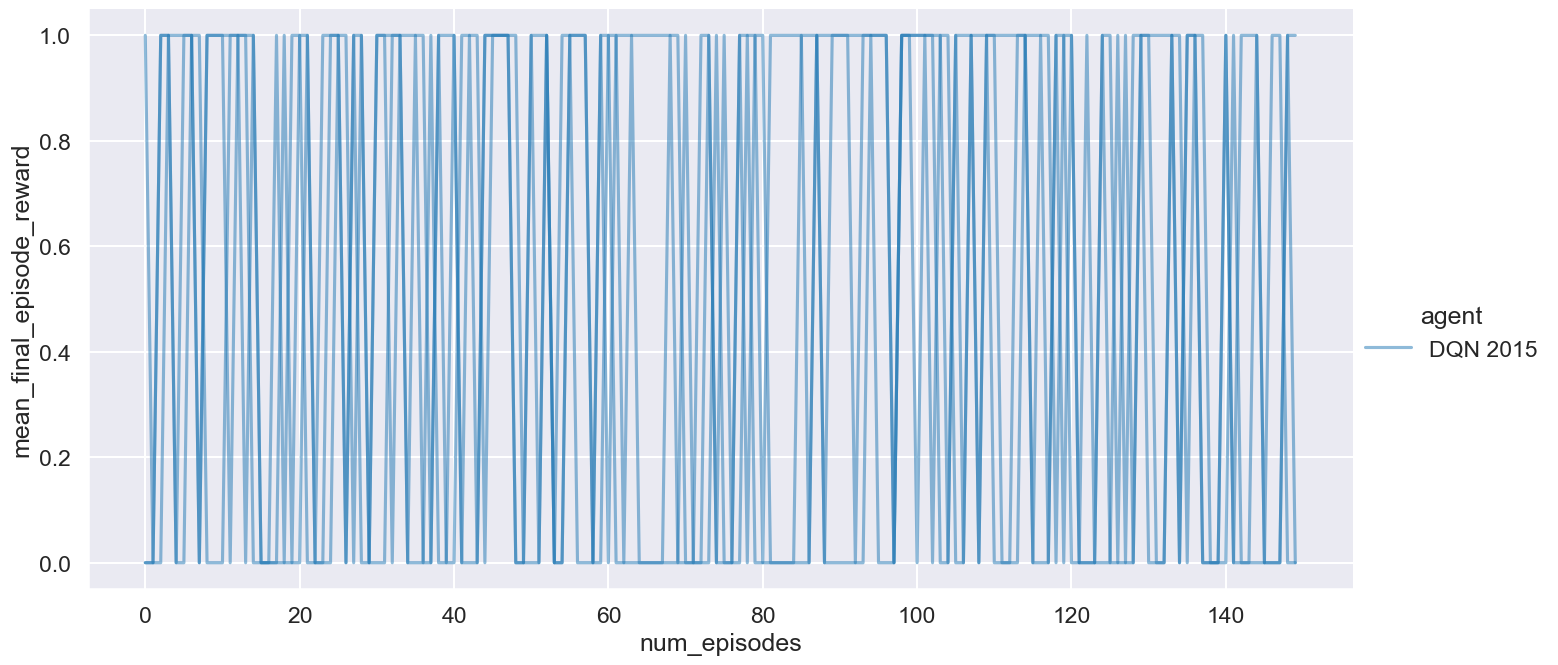

In [ ]:
g = sns.relplot(
    x="num_episodes",
    y="episode_reward",
    kind="line",
    hue="agent",
    estimator=None,
    data=dqn2_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)
plt.savefig(PLOTS_DIR / "dqnv2_trains_results.png")
plt.show()

### Testing Against a Random Policy

In [ ]:
results = test_functions.test_q_network_vs_random(env_port=3, num_episodes=5, q_network=dqnv2)

Connected to Java server at localhost:3

Episode 1/5
Q-Network plays second (BLUE)
Random agent plays first (RED)

Move 1
Player: Random (RED)
Selected move: E0-F1
  012345
F -RBBBQ
E --BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 2
Player: Q-Network (BLUE)
Selected move: F5-F4
  012345
F -RBBQB
E --BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position: (0,0)

Move 3
Player: Random (RED)
Selected move: F1-E2
  012345
F --BBQB
E --RBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position: (0,0)

Move 4
Player: Q-Network (BLUE)
Selected move: F2-E2
  012345
F ---BQB
E --BBBB
D RR-BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position: (0,0)

Move 5
Player: Random (RED)
Selected move: C2-D2
  012345
F ---BQB
E --BBBB
D RRRBBB
C RR--BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,4)
RED KING Position: (0,0)

Move 6
Player: Q-Network (BLUE)
Selected move: C5-B4
  01

### Testing Against our Java ID Alpha Beta Agent

In [ ]:
results = test_functions.test_q_network_vs_alpha_beta(env_port=3, num_episodes=1, q_network=dqnv2)

Episode reward: 185.0
Episode reward: 206.0
Episode reward: 207.0

Select the episode to play here 👇



interactive(children=(Dropdown(description='file_path', options=(PosixPath('figs/lab6/lab6_ex4_dqn2_tained-epi…

#### Score

In [ ]:
train_score_dqn2 = dqn2_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby(
    "num_episodes").mean().max()
train_score_dqn2

mean_final_episode_reward    418.333333
dtype: float64

## 3. Deep policy-based Reinforcement Learning with Monte Carlo Policy Gradient (REINFORCE)

### The Policy Gradient theorem

This is a policy gradient method that directly searchs in a family of parameterized policies $\pi_\theta$ for the optimal policy.

This method performs gradient ascent in the policy space so that the total return is maximized.
We will restrict our work to episodic tasks, *i.e.* tasks that have a starting states and last for a finite and fixed number of steps $T$, called horizon.

More formally, we define an optimization criterion that we want to maximize:

$$J(\theta) = \mathbb{E}_{\pi_\theta}\left[\sum_{t=1}^T r(s_t,a_t)\right],$$

where $\mathbb{E}_{\pi_\theta}$ means $a \sim \pi_\theta(\cdot|s)$ and $T$ is the horizon of the episode.
In other words, we want to maximize the value of the starting state: $V^{\pi_\theta}(s)$.
The policy gradient theorem tells us that:

$$
\nabla_\theta J(\theta) = \nabla_\theta V^{\pi_\theta}(s) = \mathbb{E}_{\pi_\theta} \left[\nabla_\theta \log \pi_\theta (a|s) ~ Q^{\pi_\theta}(s,a) \right],
$$

where the $Q$-function is defined as:

$$Q^{\pi_\theta}(a|s) = \mathbb{E}^{\pi_\theta} \left[\sum_{t=1}^T r(s_t,a_t)|s=s_1, a=a_1\right].$$

The policy gradient theorem is particularly effective because it allows gradient computation without needing to understand the system's dynamics, as long as the $Q$-function for the current policy is computable. By simply applying the policy and observing the one-step transitions, sufficient information is gathered. Implementing a stochastic gradient ascent and substituting $Q^{\pi_\theta}(s_t,a_t)$ with a Monte Carlo estimate $R_t = \sum_{t'=t}^T r(s_{t'},a_{t'})$ for a single trajectory, we derive the REINFORCE algorithm.

The REINFORCE algorithm, introduced by Williams in 1992, is a Monte Carlo policy gradient method. It updates the policy in the direction that maximizes rewards, using full-episode returns as an unbiased estimate of the gradient. Each step involves generating an episode using the current policy, computing the gradient estimate, and updating the policy parameters. This algorithm is simple yet powerful, and it's particularly effective in environments where the policy gradient is noisy or the dynamics are complex.

For further reading and a deeper understanding, refer to Williams' seminal paper (https://link.springer.com/article/10.1007/BF00992696) and the comprehensive text on reinforcement learning by Richard S. Sutton and Andrew G. Barto: "Reinforcement Learning: An Introduction", chap.13 (http://incompleteideas.net/book/RLbook2020.pdf).

Here is the REINFORCE algorithm.

### Monte Carlo policy gradient (REINFORCE)

<b>REQUIRE</b> <br>
$\quad$ A differentiable policy $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ A learning rate $\alpha \in \mathbb{R}^+$ <br>
<b>INITIALIZATION</b> <br>
$\quad$ Initialize parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ <br>
<br>
<b>FOR EACH</b> episode <br>
$\quad$ Generate full trace $\tau = \{ \boldsymbol{s}_0, \boldsymbol{a}_0, r_1, \boldsymbol{s}_1, \boldsymbol{a}_1, \dots, r_T, \boldsymbol{s}_T \}$ following $\pi_{\boldsymbol{\theta}}$ <br>
$\quad$ <b>FOR</b> $~ t=0,\dots,T-1$ <br>
$\quad\quad$ $G \leftarrow \sum_{k=t}^{T-1} r_k$ <br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow \boldsymbol{\theta} + \alpha ~ \underbrace{G ~ \nabla_{\boldsymbol{\theta}} \ln \pi_{\boldsymbol{\theta}}(\boldsymbol{a}_t|\boldsymbol{s}_t)}_{\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta})}$ <br>
<br>
<b>RETURN</b> $\boldsymbol{\theta}$

### 3.1 Policy Implementation

We will implement a stochastic policy to control the agent's actions.

The network takes an input tensor representing the state of the environment and outputs a tensor of action probabilities.

In [24]:
class PolicyNetwork(nn.Module):
    """
    A neural network used as a policy for the REINFORCE algorithm.

    Attributes
    ----------
    layer1 : torch.nn.Linear
        A fully connected layer.

    Methods
    -------
    forward(state: torch.Tensor) -> torch.Tensor
        Define the forward pass of the PolicyNetwork.
    """

    def __init__(self, board_size=6, action_space_size=None):
        """
       Initialize a new instance of PolicyNetwork.

       Parameters
       ----------
       n_observations : int
           The size of the observation space.
       n_actions : int
           The size of the action space.
       """
        super(PolicyNetwork, self).__init__()

        # Input: 6 channels representing the board state
        self.board_size = board_size
        if action_space_size is None:
            self.action_space_size = board_size * board_size * board_size * board_size
        else:
            self.action_space_size = action_space_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(6, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        # Calculate the size after convolutions
        conv_output_size = 128 * board_size * board_size

        # Fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, self.action_space_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """
        Calculate the probability of each action for the given state.

        Parameters
        ----------
        state_tensor : torch.Tensor
            The input tensor (state).
            The shape of the tensor should be (N, dim),
            where N is the number of states vectors in the batch
            and dim is the dimension of state vectors.

        Returns
        -------
        torch.Tensor
            The output tensor (the probability of each action for the given state).
        """
        # Convolutional layers with batch normalization and ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer with logits (will be converted to probabilities with softmax)
        x = self.fc3(x)

        return x

    def get_params(self) -> np.ndarray:
        """
        Get the parameters.

        Returns
        -------
        np.ndarray
            The parameters of the model.
        """
        return self.params.copy()

    def set_params(self, params: np.ndarray) -> None:
        """
        Set the parameters.

        Parameters
        ----------
        params : np.ndarray
            The parameters of the model.
        """
        self.params = params.copy()

    def sample_discrete_action(
            self,
            env,
            state: torch.Tensor,
            train: bool = False
    ) -> Tuple[int, torch.Tensor]:
        """
        Sample a discrete action based on the given state and policy network.

        This function takes a state and a policy network, and returns a sampled action and its log probability.
        The action is sampled from a categorical distribution defined by the output of the policy network.

        Parameters
        ----------
        env: KingAndCourtesanEnv
            The gane environment
        state : numpy.ndarray
            The state based on which an action needs to be sampled.

        train: bool
            Wether we're training the network or not

        Returns
        -------
        Tuple[int, torch.Tensor]
            The sampled action and its log probability.

        """

        # Convert state to tensor
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        # Get action logits from policy network
        if not train:
            with torch.no_grad():
                action_logits = self(state_tensor)
        else:
            action_logits = self(state_tensor)

        # Create mask for legal moves
        legal_moves = env.legal_moves
        mask = torch.ones_like(action_logits) * float('-inf')

        for move in legal_moves:
            move_idx = env._move_to_index(move)
            mask[0, move_idx] = 0

        # Apply mask to logits
        masked_logits = action_logits + mask

        # Convert to probabilities
        probs = F.softmax(masked_logits, dim=1)

        # Create categorical distribution
        m = torch.distributions.Categorical(probs)

        # Sample action
        action = m.sample()

        # Get log probability
        log_prob = m.log_prob(action)

        return action.item(), log_prob

    @classmethod
    def sample_one_episode(
            cls,
            env,
            policy_nn,
            policy_nn_adversary=None,
            max_episode_duration=500,
            gamma=0.99,
            train=False
    ) -> Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]:
        """
        Execute one episode within the `env` environment utilizing the policy defined by the `policy_nn` parameter.

        Parameters
        ----------
        env : gym.Env
            The environment to play in.
        policy_nn : PolicyNetwork
            The policy neural network.
        policy_nn_adversary : PolicyNetwork
            The adversary policy neural network.
        max_episode_duration : int
            The maximum duration of the episode.
        gamma : float
            Discount factor.
        train : bool
            Wether we're training the networks or not


        Returns
        -------
        Tuple[List[np.ndarray], List[int], List[float], List[torch.Tensor]]
            The states, actions, rewards, and log probability of action for each time step in the episode.
        """
        # If adversary not provided, use main policy
        if policy_nn_adversary is None:
            policy_nn_adversary = policy_nn

        # Initialize trajectory data structures for main agent only
        main_states = []
        main_actions = []
        main_rewards = []
        main_log_probs = []

        # Reset environment
        state, info = env.reset()
        done = False

        # Determine player roles based on environment's random assignment
        is_main_first = env.is_first_player  # True if main agent plays first (RED)

        # Initialize player turn
        current_player = 0  # 0 for first player (RED), 1 for second player (BLUE)

        t = 0
        while t < max_episode_duration and not done:
            # Determine if it's main agent's turn
            is_main_turn = (current_player == 0 and is_main_first) or (current_player == 1 and not is_main_first)

            # If it's main agent's turn, store the state
            if is_main_turn:
                main_states.append(state)
                action, log_prob = policy_nn.sample_discrete_action(env, state, train=train)
                main_actions.append(action)
                main_log_probs.append(log_prob)
            else:
                # Adversary policy's turn
                action, _ = policy_nn_adversary.sample_discrete_action(env, state, train=train)

            # Execute action in environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # If it's main agent's turn, store the reward
            if is_main_turn:
                main_rewards.append(reward)

            # Prepare for next step
            state = next_state
            current_player = 1 - current_player  # Switch player
            t += 1

        # Calculate returns for each timestep the main agent acted
        returns = []
        G = 0
        # Process rewards in reverse order (from last to first)
        for r in reversed(main_rewards):
            G = r + gamma * G
            returns.insert(0, G)  # Insert at the beginning to maintain original order

        return main_states, main_actions, returns, main_log_probs

#### Testing the untrained agent against itself

In [ ]:
num_episodes = 1

In [ ]:
# Initialize Policy-Networks
policy_network = PolicyNetwork(board_size=BOARD_SIZE).to(device)
policy_network_adversary = PolicyNetwork(board_size=BOARD_SIZE).to(device)

print(f"Starting Policy-Network vs Policy-Network test...")
print(f"Board size: {BOARD_SIZE}x{BOARD_SIZE}")

# Run test
stats = test_functions.test_policy_network_agent(
    env_port=3,
    policy_network=policy_network,
    policy_network_adversary=policy_network_adversary,
    num_episode=num_episodes,
    render=(render_mode == 'human'),
)

print("\nGame Results:")
print(f"Winner: {stats['winner']}")
print(f"Steps: {stats['steps']}")
print(f"Main Network played as: {stats['main_network_role']}")
print(f"Adversary Network played as: {stats['adversary_role']}")

Starting Policy-Network vs Policy-Network test...
Board size: 6x6
Connected to Java server at localhost:3
Main agent plays first (RED)
Adversary plays second (BLUE)
Move 1, Player: RED
Selected move: D1-E2
  012345
F -BBBBQ
E R-RBBB
D R--BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 2, Player: BLUE
Selected move: B5-B4
  012345
F -BBBBQ
E R-RBBB
D R--BBB
C RRR-BB
B RRRRB-
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)
Move 3, Player: RED
Selected move: A0-A1
  012345
F -BBBBQ
E R-RBBB
D R--BBB
C RRR-BB
B RRRRB-
A RKRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,1)
Move 4, Player: BLUE
Selected move: E3-D2
  012345
F -BBBBQ
E R-R-BB
D R-BBBB
C RRR-BB
B RRRRB-
A RKRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,1)
Move 5, Player: RED
Selected move: C1-D1
  012345
F -BBBBQ
E R-R-BB
D RRBBBB
C R-R-BB
B RRRRB-
A RKRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,1)
Move 6, Player: BLUE
Selected move: F5-F4
  012345
F -BBBQ

#### Testing the untrained agent against random agent

In [ ]:
policy_network = PolicyNetwork(board_size=BOARD_SIZE).to(device)
results = test_functions.test_policy_network_vs_random(env_port=3, num_episodes=5, policy_network=policy_network)

Connected to Java server at localhost:3

Episode 1/5
Policy Network plays first (RED)
Random agent plays second (BLUE)

Move 1
Player: Policy Network (RED)
Selected move: D1-E2
  012345
F -BBBBQ
E R-RBBB
D R--BBB
C RRR-BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 2
Player: Random (BLUE)
Selected move: C4-B4
  012345
F -BBBBQ
E R-RBBB
D R--BBB
C RRR--B
B RRRRBB
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 3
Player: Policy Network (RED)
Selected move: A4-B4
  012345
F -BBBBQ
E R-RBBB
D R--BBB
C RRR--B
B RRRRRB
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 4
Player: Random (BLUE)
Selected move: D4-C4
  012345
F -BBBBQ
E R-RBBB
D R--B-B
C RRR-BB
B RRRRRB
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 5
Player: Policy Network (RED)
Selected move: E0-E1
  012345
F -BBBBQ
E -RRBBB
D R--B-B
C RRR-BB
B RRRRRB
A KRRR--
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 6
Player: Random (BLUE)
Selec

#### Test Function

`avg_return_on_multiple_episodes` function tests the given policy $\pi_\theta$ on `num_episodes` episodes (for fixed horizon $T$) and returns the average reward on the `num_episodes` episodes.

The function `avg_return_on_multiple_episodes` is designed to play multiple episodes of a given environment using a specified policy neural network and calculate the average return. It takes as input the environment to play in, the policy neural networks to use, the number of episodes to play and the maximum duration of an episode.
In each episode, it uses the `sample_one_episode` function to play the episode and collect the rewards. The function then returns the average of these cumulated rewards.

`avg_return_on_multiple_episodes` will be used for evaluating the performance of a policy over multiple episodes.

In [25]:
def avg_return_on_multiple_episodes(
        env: gym.Env,
        policy_nn: PolicyNetwork,
        policy_nn_adversary: PolicyNetwork,
        num_test_episode: int,
        max_episode_duration: int | float = 500,
        gamma: float = 0.99,
        verbose: bool = False
) -> float:
    """
    Play multiple episodes of the environment and calculate the average return.

    Parameters
    ----------
    env : gym.Env
        The environment to play in.
    policy_nn : PolicyNetwork
        The policy neural network.
    policy_nn_adversary : PolicyNetwork
        The adversary policy neural network.
    num_test_episode : int
        The number of episodes to play.
    max_episode_duration : int
        The maximum duration of an episode.
    gamma : float
        Discount factor.
    verbose : bool
        Wether to print detailed information

    Returns
    -------
    float
        The average return.
    """
    policy_network_class = policy_nn.__class__
    total_return = 0.0
    episode_returns = []

    for episode in range(num_test_episode):
        if verbose:
            print(f"Evaluating episode {episode + 1}/{num_test_episode}")

        # Sample an episode using the policy networks
        _, _, returns, _ = policy_network_class.sample_one_episode(
            env=env,
            policy_nn=policy_nn,
            policy_nn_adversary=policy_nn_adversary,
            max_episode_duration=max_episode_duration,
            gamma=gamma
        )

        # Calculate the episode return
        if returns:  # Check if returns list is not empty
            # The first element in returns is the cumulative discounted return for the whole episode
            episode_return = returns[0]
            total_return += episode_return
            episode_returns.append(episode_return)

            if verbose:
                print(f"Episode {episode + 1} return: {episode_return:.2f}")
        else:
            # Handle case where no returns were collected (e.g., if the main agent never got to act)
            if verbose:
                print(f"Episode {episode + 1}: No returns collected")

    # Calculate average return
    if episode_returns:
        average_return = total_return / len(episode_returns)
    else:
        average_return = 0.0

    if verbose:
        print(f"Average return over {num_test_episode} episodes: {average_return:.2f}")
        if len(episode_returns) > 1:
            print(f"Min return: {min(episode_returns):.2f}, Max return: {max(episode_returns):.2f}")

    return average_return

Testing this function on the untrained agent.

In [ ]:
port = 3
render_mode = 'human'

In [ ]:
policy_network = PolicyNetwork(board_size=BOARD_SIZE).to(device)
policy_network_adversary = PolicyNetwork(board_size=BOARD_SIZE).to(device)

In [ ]:
env = kac.KingAndCourtesanEnv(port=port, render_mode=render_mode)

average_return = avg_return_on_multiple_episodes(env=env, policy_nn=policy_network,
                                                 policy_nn_adversary=policy_network_adversary, num_test_episode=5,
                                                 verbose=True)

print(average_return)

env.close()

Connected to Java server at localhost:3
Evaluating episode 1/5
Episode 1 return: 0.00
Evaluating episode 2/5
Episode 2 return: 0.70
Evaluating episode 3/5
Episode 3 return: 0.76
Evaluating episode 4/5
Episode 4 return: 0.00
Evaluating episode 5/5
Episode 5 return: 0.78
Average return over 5 episodes: 0.45
Min return: 0.00, Max return: 0.78
0.4473154583591647
Connection to Java server closed


### 3.2 Train Function

`train_reinforce_discrete` trains a policy network using the REINFORCE algorithm in the given environment. This function takes as input the environment, the number of training episodes, the number of tests to perform per episode, the maximum duration of an episode, and the learning rate for the optimizer.

The function first initializes a policy network and an AdamW optimizer. Then, for each training episode, it generates an episode using the current policies (current player and adversary) and calculates the return at each time step. It uses this return and the log probability of the action taken at that time step to compute the loss, which is the negative of the product of the return and the log probability. This loss is used to update the policy network parameters using gradient ascent.

After each training episode, the function tests the current policy by playing a number of test episodes and calculating the average return. This average return is added to a list for monitoring purposes.

The function returns the trained policy network and the list of average returns for each episode. This function encapsulates the main loop of the REINFORCE algorithm, including the policy update step.

In [30]:
def train_reinforce_discrete(
        env: gym.Env,
        num_episodes: int = 5000,
        max_episode_duration: int | float = 500,
        learning_rate: float = 0.001,
        gamma: float = 0.99,
        entropy_coef: float = 0.01,  # entropy regularization coefficient
        grad_clip: float = 10.0,  # gradient clipping threshold
        eval_frequency: int = 50,  # evaluation frequency
        verbose: bool = False,
        checkpoint_dir: str = 'checkpoints/reinforce',
        checkpoint_frequency: int = 50,
        save_best_only: bool = False,
) -> Tuple[PolicyNetwork, List[float], List[float], List[float]]:
    """
    Enhanced training function for REINFORCE algorithm with self-play.

    Parameters
    ----------
    env : gym.Env
        The environment to train in.
    num_episodes : int
        The number of training episodes.
    num_test_per_episode : int
        The number of tests to perform per episode.
    max_episode_duration : int
        The maximum length of an episode.
    learning_rate : float
        The initial step size.
    gamma : float
        Discount factor for future rewards.
    entropy_coef : float
        Coefficient for entropy regularization.
    grad_clip : float
        Gradient clipping parameter.
    eval_frequency : int
        Frequency of evaluation.
    verbose : bool
        Whether to print detailed progress information.
    checkpoint_dir : str
        Directory to save checkpoints.
    checkpoint_frequency : int
        How often to save checkpoints.
    save_best_only : bool
        Whether to save only the best performing policy
    Returns
    -------
    Tuple[PolicyNetwork, List[float], List[float], List[float]]
        The final trained policy, episode win rates and losses
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    best_win_rate = float('-inf')

    episodes_win_rates = []
    main_network_episodes_losses = []
    adversary_network_episodes_losses = []

    # Initialize policy networks
    policy_nn = PolicyNetwork(board_size=env.board_size).to(device)
    policy_nn_adversary = PolicyNetwork(board_size=env.board_size).to(device)

    # Initialize optimizers with weight decay
    optimizer = torch.optim.AdamW(
        policy_nn.parameters(),
        lr=learning_rate,
        weight_decay=1e-5  # L2 regularization
    )
    optimizer_adversary = torch.optim.AdamW(
        policy_nn_adversary.parameters(),
        lr=learning_rate,
        weight_decay=1e-5
    )

    # Initialize cosine annealing learning rate schedulers with warm restarts
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=500,  # Restart period
        T_mult=2,  # Increase period after each restart
        eta_min=1e-5  # Minimum learning rate
    )
    lr_scheduler_adversary = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer_adversary,
        T_0=500,
        T_mult=2,
        eta_min=1e-5
    )

    # Training loop
    for episode_index in tqdm(range(num_episodes)):
        # MAIN AGENT TRAINING
        # Sample an episode from main agent's perspective
        main_states, main_actions, main_returns, main_log_probs = PolicyNetwork.sample_one_episode(
            env=env,
            policy_nn=policy_nn,
            policy_nn_adversary=policy_nn_adversary,
            max_episode_duration=max_episode_duration,
            gamma=gamma,
            train=True
        )

        # Update main policy if it collected any experiences
        if main_actions:
            # Normalize returns for more stable training
            # if len(main_returns) > 1:
            #    main_returns_tensor = torch.FloatTensor(main_returns).to(device)
            #   main_returns_normalized = (main_returns_tensor - main_returns_tensor.mean()) / (main_returns_tensor.std() + 1e-8)
            # else:
            # main_returns_normalized = torch.FloatTensor(main_returns).to(device)

            # Compute policy loss with entropy regularization
            policy_loss = 0
            entropy = 0

            for t in range(len(main_returns)):
                # Policy gradient loss
                policy_loss -= main_log_probs[t] * main_returns[t]

                # Entropy regularization (encourage exploration)
                entropy -= main_log_probs[t].exp() * main_log_probs[t]

            # Combine losses with coefficients
            total_loss = policy_loss - entropy_coef * entropy

            # Gradient update for main policy
            optimizer.zero_grad()
            total_loss.backward()

            # Apply gradient clipping
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(policy_nn.parameters(), grad_clip)

            optimizer.step()
            lr_scheduler.step()

            if verbose and episode_index % 10 == 0:
                print(
                    f"Episode {episode_index + 1} - Main Policy Loss: {policy_loss.item():.4f}, Entropy: {entropy.item():.4f}")

        # ADVERSARY TRAINING
        # Sample episode from adversary's perspective
        adv_states, adv_actions, adv_returns, adv_log_probs = PolicyNetwork.sample_one_episode(
            env=env,
            policy_nn=policy_nn_adversary,
            policy_nn_adversary=policy_nn,
            max_episode_duration=max_episode_duration,
            gamma=gamma,
            train=True
        )

        # Update adversary policy if it collected any experiences
        if adv_actions:
            # Normalize returns for more stable training
            # if len(adv_returns) > 1:
            #     adv_returns_tensor = torch.FloatTensor(adv_returns).to(device)
            #     adv_returns_normalized = (adv_returns_tensor - adv_returns_tensor.mean()) / (adv_returns_tensor.std() + 1e-8)
            # else:
            #     adv_returns_normalized = torch.FloatTensor(adv_returns).to(device)

            # Compute policy loss with entropy regularization
            adv_policy_loss = 0
            adv_entropy = 0

            for t in range(len(adv_returns)):
                # Policy gradient loss
                adv_policy_loss -= adv_log_probs[t] * adv_returns[t]

                # Entropy regularization (encourage exploration)
                adv_entropy -= adv_log_probs[t].exp() * adv_log_probs[t]

            # Combine losses with coefficients
            adv_total_loss = adv_policy_loss - entropy_coef * adv_entropy

            # Gradient update for adversary policy
            optimizer_adversary.zero_grad()
            adv_total_loss.backward()

            # Apply gradient clipping
            if grad_clip > 0:
                torch.nn.utils.clip_grad_norm_(policy_nn_adversary.parameters(), grad_clip)

            optimizer_adversary.step()
            lr_scheduler_adversary.step()

        # Evaluate periodically
        if (episode_index + 1) % eval_frequency == 0 or episode_index == 0:
            print(f"\nEpisode {episode_index + 1}/{num_episodes}")
            print(f"Loss - Main: {total_loss.item():.4f}, Adv: {adv_total_loss.item():.4f}")
            if lr_scheduler is not None:
                print(f"Learning rate - Main: {lr_scheduler.get_last_lr()[0]:.6f}")

            test_win_rate = (
                test_functions.test_policy_network_vs_alpha_beta(env_port=3, agent_port=9, num_episodes=1,
                                                                 policy_network=policy_nn,
                                                                 ))['policy_network_win_rate']

            episodes_win_rates.append(test_win_rate)

            # Print progress if verbose
            if verbose:
                print(f"\nEpisode {episode_index + 1}/{num_episodes}")
                print(f"Win rate: {test_win_rate:.4f}")
                print(f"Learning Rate: {lr_scheduler.get_last_lr()[0]:.6f}")

            # Save best model if performance improved
            if test_win_rate > best_win_rate:
                best_win_rate = test_win_rate
                checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
                torch.save({
                    'episode': episode_index,
                    'policy_nn_state_dict': policy_nn.state_dict(),
                    'policy_nn_adversary_state_dict': policy_nn_adversary.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'optimizer_adversary_state_dict': optimizer_adversary.state_dict(),
                    'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                    'lr_scheduler_adversary_state_dict': lr_scheduler_adversary.state_dict(),
                    'best_win_rate': best_win_rate
                }, checkpoint_path)
                print(
                    f"Saved best model with win rate: {best_win_rate:.2f} at episode {episode_index + 1}/{num_episodes}")

        # Save checkpoint at regular intervals
        if (episode_index + 1) % checkpoint_frequency == 0 and not save_best_only:
            main_network_episodes_losses.append(total_loss.item())
            adversary_network_episodes_losses.append(adv_total_loss.item())
            checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_episode_{episode_index + 1}.pt')
            torch.save({
                'episode': episode_index,
                'policy_nn_state_dict': policy_nn.state_dict(),
                'policy_nn_adversary_state_dict': policy_nn_adversary.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'optimizer_adversary_state_dict': optimizer_adversary.state_dict(),
                'lr_scheduler_state_dict': lr_scheduler.state_dict(),
                'lr_scheduler_adversary_state_dict': lr_scheduler_adversary.state_dict(),
                'win_rates_list': episodes_win_rates,
                'main_network_episodes_losses': main_network_episodes_losses,
                'adversary_network_episodes_losses': adversary_network_episodes_losses
            }, checkpoint_path)
            print(f"Saved checkpoint at episode {episode_index + 1}/{num_episodes}")

    return policy_nn, episodes_win_rates, main_network_episodes_losses, adversary_network_episodes_losses

#### Training the agent

In [33]:
env = kac.KingAndCourtesanEnv(
    port=3,
)

#for train_index in range(NUMBER_OF_TRAININGS):
reinforce_policy_nn, episodes_win_rates, main_network_episodes_losses, adversary_network_episodes_losses = train_reinforce_discrete(
    env=env,
    num_episodes=10000,
    max_episode_duration=float('inf'),
    learning_rate=0.001,
    gamma=0.99,
    entropy_coef=0.01,  # Entropy regularization
    grad_clip=10.0,  # Gradient clipping
    eval_frequency=1000,  # Evaluate every 50 episodes
    verbose=True
)

Connected to Java server at localhost:3


  0%|          | 0/10000 [00:00<?, ?it/s]

Episode 1 - Main Policy Loss: 0.0000, Entropy: 6.2538

Episode 1/10000
Loss - Main: -0.0625, Adv: -0.0588
Learning rate - Main: 0.001000
Connected to Java server at localhost:3
Connected to ID Alpha-Beta server at localhost:9
ID AlphaBeta reset
ID Alpha-Beta reset response: {'current_role': 'RED', 'ai_role': 'BLUE', 'legal_moves': ['A0-A1', 'A0-B0', 'A0-B1', 'A3-B4', 'A4-A5', 'A4-B4', 'A4-B5', 'B2-C3', 'B3-B4', 'B3-C3', 'B3-C4', 'C1-D2', 'C2-C3', 'C2-D2', 'C2-D3', 'D0-E1', 'D1-D2', 'D1-E1', 'D1-E2', 'E0-E1', 'E0-F0', 'E0-F1'], 'board': [['RED_KING', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COU

KeyboardInterrupt: 

In [ ]:
torch.save(reinforce_policy_nn, MODELS_DIR / "reinforce_policy_network.pth")

In [ ]:
joblib.dump({'episodes_win_rates': episodes_win_rates, 'main_network_episodes_losses': main_network_episodes_losses,
             'adversary_network_episodes_losses': adversary_network_episodes_losses}, 'reinforce_train_stats')

In [ ]:
reinforce_trains_result_list: List[List[Union[int, float]]] = [[], []]
reinforce_trains_result_list[0] = list(range(len(episodes_win_rates)))
reinforce_trains_result_list[1] = episodes_win_rates

reinforce_trains_result_df = pd.DataFrame(
    np.array(reinforce_trains_result_list).T,
    columns=["num_episodes", "win_rate"],
)
reinforce_trains_result_df["agent"] = "REINFORCE"

env.close()

Connected to Java server at localhost:3


  0%|          | 0/150 [00:00<?, ?it/s]

Training complete - Final Average Return: 0.4374


  0%|          | 0/150 [00:00<?, ?it/s]

Training complete - Final Average Return: 0.1373


  0%|          | 0/150 [00:00<?, ?it/s]

Training complete - Final Average Return: 0.0000
Connection to Java server closed


#### Plots

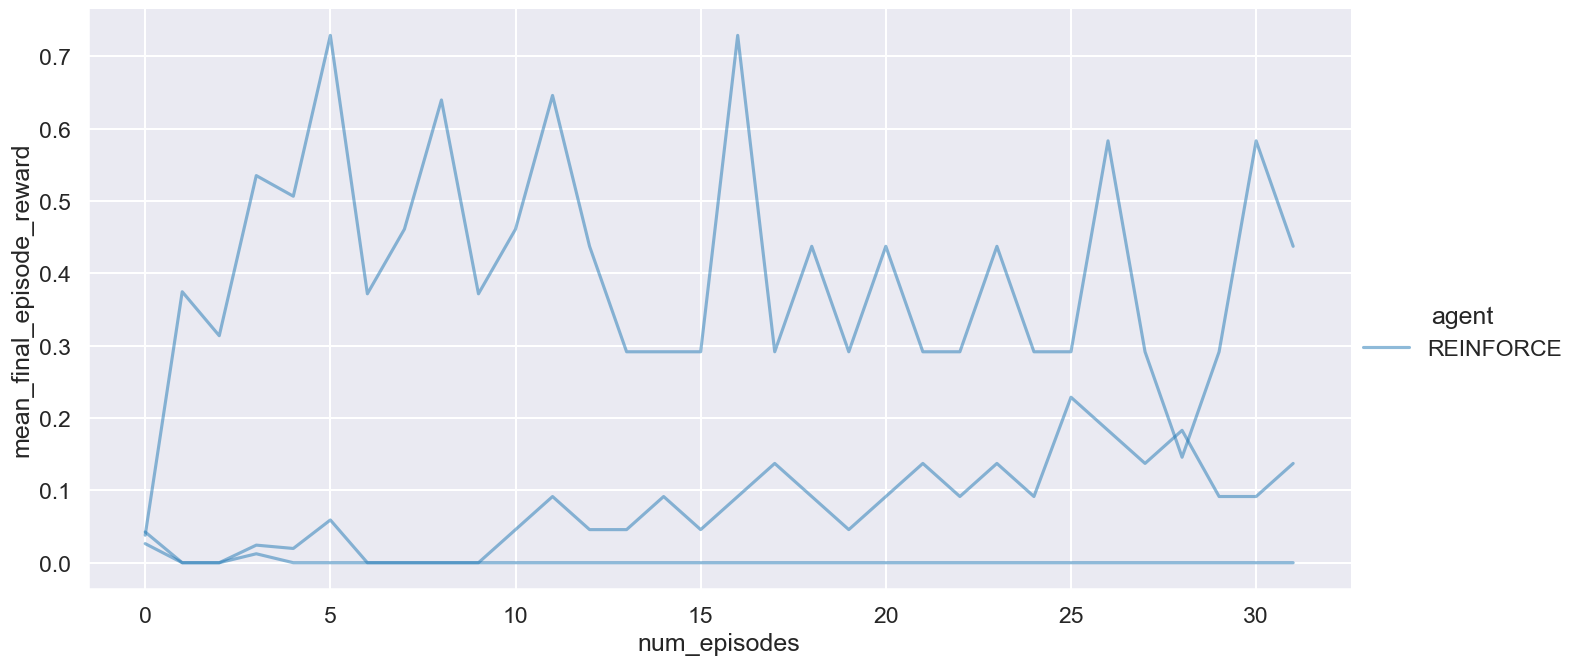

In [ ]:
g = sns.relplot(
    x="num_episodes",
    y="win_rate",
    kind="line",
    hue="agent",
    estimator=None,
    data=reinforce_trains_result_df,
    height=7,
    aspect=2,
    alpha=0.5,
)
plt.savefig(PLOTS_DIR / "reinforce_trains_results.png")
plt.show()

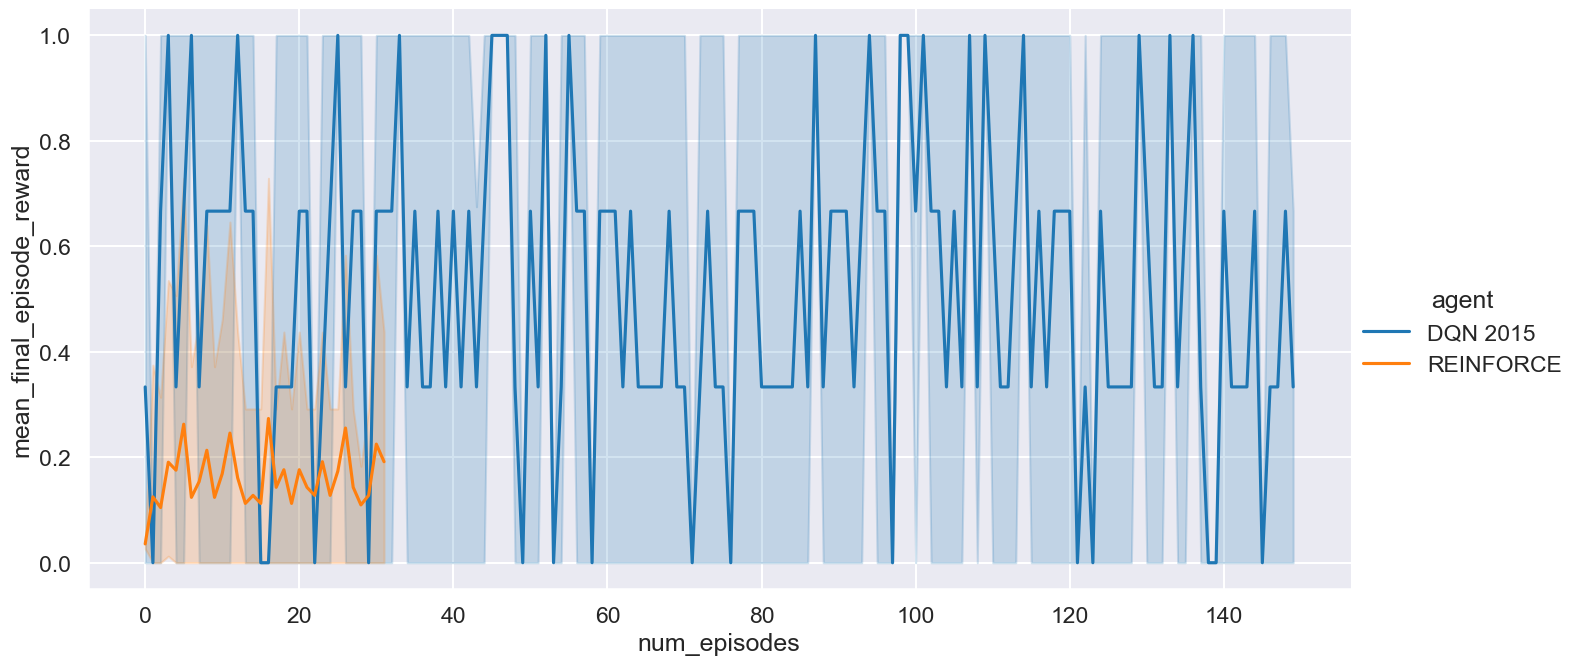

In [ ]:
all_trains_result_df = pd.concat(
    [
        dqn2_trains_result_df,
        reinforce_trains_result_df,
    ]
)
g = sns.relplot(
    x="num_episodes",
    y="episode_reward",
    kind="line",
    hue="agent",
    data=all_trains_result_df,
    height=7,
    aspect=2,
)
plt.savefig(PLOTS_DIR / "trains_results_agg.png")
plt.show()

### Testing the agent against a random policy

In [ ]:
results = test_functions.test_policy_network_vs_random(env_port=3, num_episodes=5, policy_network=reinforce_policy_nn)

Connected to Java server at localhost:3

Episode 1/5
Policy Network plays first (RED)
Random agent plays second (BLUE)

Move 1
Player: Policy Network (RED)
Selected move: C2-D3
  012345
F -BBBBQ
E R-BBBB
D RR-RBB
C RR--BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 2
Player: Random (BLUE)
Selected move: E3-D3
  012345
F -BBBBQ
E R-B-BB
D RR-BBB
C RR--BB
B RRRR-B
A KRRRR-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 3
Player: Policy Network (RED)
Selected move: A3-B4
  012345
F -BBBBQ
E R-B-BB
D RR-BBB
C RR--BB
B RRRRRB
A KRR-R-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 4
Player: Random (BLUE)
Selected move: C4-B3
  012345
F -BBBBQ
E R-B-BB
D RR-BBB
C RR---B
B RRRBRB
A KRR-R-
BLUE KING Position: (5,5)
RED KING Position: (0,0)

Move 5
Player: Policy Network (RED)
Selected move: A0-B1
  012345
F -BBBBQ
E R-B-BB
D RR-BBB
C RR---B
B RKRBRB
A RRR-R-
BLUE KING Position: (5,5)
RED KING Position: (1,1)

Move 6
Player: Random (BLUE)
Selec

### Testing the agent against our Java ID Alpha Beta agent

In [ ]:
reinforce_policy_nn = torch.load(MODELS_DIR / "reinforce_policy_network.pth", map_location=device)

/var/folders/zd/6gytrrmd0jx86dlhrkrlp1d80000gn/T/ipykernel_9444/1509281960.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reinforce_policy_nn = torch.load(MODELS_DIR / 

In [ ]:
results = test_functions.test_policy_network_vs_alpha_beta(env_port=3, num_episodes=1,
                                                           policy_network=reinforce_policy_nn, agent_port=3)

Connected to Java server at localhost:3
Connected to ID Alpha-Beta server at localhost:3
ID Alpha-Beta reset response: {'current_role': 'RED', 'ai_role': 'BLUE', 'legal_moves': ['A0-A1', 'A0-B0', 'A0-B1', 'A3-B4', 'A4-A5', 'A4-B4', 'A4-B5', 'B2-C3', 'B3-B4', 'B3-C3', 'B3-C4', 'C1-D2', 'C2-C3', 'C2-D2', 'C2-D3', 'D0-E1', 'D1-D2', 'D1-E1', 'D1-E2', 'E0-E1', 'E0-F0', 'E0-F1'], 'board': [['RED_KING', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['RED_COURTESAN', 'EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN'], ['EMPTY', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_COURTESAN', 'BLUE_KING']]}

Episode 1/1
Policy Network pla

KeyboardInterrupt: 

#### Score

In [ ]:
train_score_reinforce = reinforce_trains_result_df[["num_episodes", "mean_final_episode_reward"]].groupby(
    "num_episodes").mean().max()
train_score_reinforce

## 4. Gradient-Free Optimization - CEM / ES

### 4.1 Objective Function

In Reinforcement Learning, by convention the score is a reward to maximize whereas in mathematical optimization the score is a cost to minimize; the objective function will therefore return the opposite of the reward as the score of evaluated policies.

In [ ]:
class ObjectiveFunction:
    """
    Objective function for evaluating a policy in a given environment.

    Parameters
    ----------
    env : gym.Env
        The environment in which to evaluate the policy.
    policy : torch.nn.Module
        The policy to evaluate.
    adversary_policy : torch.nn.Module
        The adversary policy.
    num_episodes : int, optional
        The number of episodes to run for each evaluation, by default 1.
    max_time_steps : float, optional
        The maximum number of time steps per episode, by default float("inf").
    minimization_solver : bool, optional
        Whether the solver is a minimization solver, by default True.

    Attributes
    ----------
    env : gym.Env
        The environment in which to evaluate the policy.
    policy : torch.nn.Module
        The policy to evaluate.
    num_episodes : int
        The number of episodes to run for each evaluation.
    max_time_steps : float
        The maximum number of time steps per episode.
    minimization_solver : bool
        Whether the solver is a minimization solver.
    num_evals : int
        The number of evaluations performed.
    """

    def __init__(
            self,
            env: gym.Env,
            policy: torch.nn.Module,
            adversary_policy: torch.nn.Module,
            num_episodes: int = 1,
            max_time_steps: float = float("inf"),
            minimization_solver: bool = True,
    ):
        self.env = env
        self.policy = policy
        self.adversary_policy = adversary_policy
        self.num_episodes = num_episodes
        self.max_time_steps = max_time_steps
        self.minimization_solver = minimization_solver

        self.num_evals = 0

    def eval(self, policy_params: np.ndarray, num_episodes: Optional[int] = None,
             max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate a policy.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters of the policy to evaluate.
        num_episodes : int, optional
            The number of episodes to run for each evaluation, by default None.
        max_time_steps : float, optional
            The maximum number of time steps per episode, by default None.

        Returns
        -------
        float
            The average total rewards over the evaluation episodes.
        """
        self.policy.set_params(policy_params)

        self.num_evals += 1

        if num_episodes is None:
            num_episodes = self.num_episodes

        if max_time_steps is None:
            max_time_steps = self.max_time_steps

        average_total_rewards = 0

        for i_episode in range(num_episodes):
            total_rewards = 0.0
            observation, info = self.env.reset()

            for t in range(max_time_steps):
                action = self.policy(observation)
                observation, reward, terminated, truncated, info = self.env.step(action)
                total_rewards += reward

                done = terminated or truncated

                if done:
                    break

            #print(f"Episode {i_episode} total rewards: {total_rewards}")

            average_total_rewards += float(total_rewards) / num_episodes

        if self.minimization_solver:
            average_total_rewards *= -1.0

        return average_total_rewards  # Optimizers do minimization by default...

    def __call__(self, policy_params: np.ndarray, num_episodes: Optional[int] = None,
                 max_time_steps: Optional[float] = None) -> float:
        """
        Evaluate a policy.

        Parameters
        ----------
        policy_params : np.ndarray
            The parameters of the policy to evaluate.
        num_episodes : int, optional
            The number of episodes to run for each evaluation, by default None.
        max_time_steps : float, optional
            The maximum number of time steps per episode, by default None.

        Returns
        -------
        float
            The average total rewards over the evaluation episodes.
        """
        return self.eval(policy_params, num_episodes, max_time_steps)

## 4.2 CEM optimization algorithm

`cem_uncorrelated` function searches the best $\theta$ parameters with a Cross Entropy Method, using the objective function defined above.
$\mathbb{P}$ can be defined as an multivariate normal distribution $\mathcal{N}\left( \boldsymbol{\mu}, \boldsymbol{\sigma^2} \boldsymbol{\Sigma} \right)$ where $\boldsymbol{\mu}$ and $\boldsymbol{\sigma^2} \boldsymbol{\Sigma}$ are vectors i.e. we use one mean and one variance parameters per dimension of $\boldsymbol{\theta}$.

**Cross Entropy**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\mathbb{P}$: family of distribution<br>
$\quad\quad$ $\boldsymbol{\theta}$: initial parameters for the proposal distribution $\mathbb{P}$<br>

**Algorithm parameter**:<br>
$\quad\quad$ $m$: sample size<br>
$\quad\quad$ $m_{\text{elite}}$: number of samples to use to fit $\boldsymbol{\theta}$<br>

**FOR EACH** iteration<br>
$\quad\quad$ samples $\leftarrow \{ \boldsymbol{x}_1, \dots, \boldsymbol{x}_m \}$ with $\boldsymbol{x}_i \sim \mathbb{P}(\boldsymbol{\theta}) ~~ \forall i \in 1\dots m$<br>
$\quad\quad$ elite $\leftarrow $ { $m_{\text{elite}}$ best samples } $\quad$ (i.e. select best samples according to $f$)<br>
$\quad\quad$ $\boldsymbol{\theta} \leftarrow $ fit $\mathbb{P}(\boldsymbol{\theta})$ to the elite samples<br>

**RETURN** $\boldsymbol{\theta}$

In [ ]:
def cem_uncorrelated(
        objective_function: Callable[[np.ndarray], float],
        mean_array: np.ndarray,
        var_array: np.ndarray,
        max_iterations: int = 500,
        sample_size: int = 50,
        elite_frac: float = 0.2,
        print_every: int = 10,
        success_score: float = float("inf"),
        num_evals_for_stop: Optional[int] = None,
        hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """
    Cross-entropy method.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The function to maximize.
    mean_array : np.ndarray
        The initial proposal distribution (mean vector).
    var_array : np.ndarray
        The initial proposal distribution (variance vector).
    max_iterations : int, optional
        Number of training iterations, by default 500.
    sample_size : int, optional
        Size of population at each iteration, by default 50.
    elite_frac : float, optional
        Rate of top performers to use in update with elite_frac ∈ ]0;1], by default 0.2.
    print_every : int, optional
        How often to print average score, by default 10.
    success_score : float, optional
        The score at which to stop the optimization, by default float("inf").
    num_evals_for_stop : Optional[int], optional
        Number of evaluations for stopping criteria, by default None.
    hist_dict : Optional[dict], optional
        Dictionary to log the history, by default None.

    Returns
    -------
    np.ndarray
        The optimized mean vector.
    """
    assert 0.0 < elite_frac <= 1.0

    n_elite = math.ceil(sample_size * elite_frac)

    for iteration_index in range(0, max_iterations):

        # SAMPLE A NEW POPULATION OF SOLUTIONS (X VECTORS) ####################

        x_array = np.random.normal(mean_array, np.sqrt(var_array), size=(sample_size, len(mean_array)))

        # EVALUATE SAMPLES AND EXTRACT THE BEST ONES ("ELITE") ################

        score_array = np.array([objective_function(x) for x in x_array])

        sorted_indices_array = np.argsort(
            score_array)
        elite_indices_array = sorted_indices_array[
                              :n_elite]

        elite_x_array = x_array[elite_indices_array]

        # FIT THE NORMAL DISTRIBUTION ON THE ELITE POPULATION #################

        mean_array = np.mean(elite_x_array, axis=0)
        var_array = np.var(elite_x_array, axis=0)
        score = np.min(score_array)

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + mean_array.tolist() + var_array.tolist()

        # STOPPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            score = objective_function(mean_array)

        # `num_evals_for_stop = None` may be used to fasten computations but it introduces bias...
        if score <= success_score:
            break

    return mean_array

### Training the agents (DQN v2 and REINFORCE) with CEM

### DQN v2

In [ ]:
env =

dqnv2_cem = QNetwork(env.observation_space.shape[0])
dqnv2_cem_adversary = QNetwork(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=dqnv2_cem, adversary_policy=dqnv2_cem_adversary, num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(dqnv2_cem.get_params())

init_mean_array = np.random.random(num_params)
init_var_array = np.ones(num_params) * 100.0

optimized_policy_params_dqnv2_cem = cem_uncorrelated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=30,
    sample_size=50,
    elite_frac=0.1,
    print_every=1,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=["score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"],
)
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "dqnv2_cem_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(20, 5)
);
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_cem_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["var1", "var2", "var3", "var4"]].plot(
    logy=True, title="Variance w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_cem_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_dqnv2_cem)

### REINFORCE

In [ ]:
reinforce_policy_nn_cem = PolicyNetwork(env.observation_space.shape[0])
reinforce_policy_nn_cem_adversary = PolicyNetwork(env.observation_space.shape[0])
objective_function = ObjectiveFunction(
    env=env, policy=dqnv2_cem, adversary_policy=reinforce_policy_nn_cem_adversary, num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(reinforce_policy_nn_cem.get_params())

optimized_policy_params_reinforce_policy_nn_cem = cem_uncorrelated(
    objective_function=objective_function,
    mean_array=init_mean_array,
    var_array=init_var_array,
    max_iterations=30,
    sample_size=50,
    elite_frac=0.1,
    print_every=1,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=["score", "mu1", "mu2", "mu3", "mu4", "var1", "var2", "var3", "var4"],
)
ax = df.score.plot(title="Average reward", figsize=(20, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_cem_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(20, 5)
);
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_cem_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["var1", "var2", "var3", "var4"]].plot(
    logy=True, title="Variance w.r.t training steps", figsize=(20, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_cem_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_reinforce_policy_nn_cem)

### Testing the trained agents againt a random policy

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_cem, adversary_policy=)

print("Average Reward (DQN v2 CEM): ",
      -objective_function.eval(optimized_policy_params_dqnv2_cem, num_episodes=NUM_EPISODES, max_time_steps=200))

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_cem, adversary_policy=)

print("Average Reward (REINFORCE CEM): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_cem, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

### Testing the trained agents againt our Java ID Alpha Beta agent

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_cem, adversary_policy=)

print("Average Reward (DQN v2 CEM): ",
      -objective_function.eval(optimized_policy_params_dqnv2_cem, num_episodes=NUM_EPISODES, max_time_steps=200))

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_cem, adversary_policy=)

print("Average Reward (REINFORCE CEM): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_cem, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

## 4.3 (1+1)-SA-ES optimization algorithm

`saes_1_1` function searchs the best $\theta$ parameters with a (1+1)-SA-ES algorithm, using the objective function defined above.

**(1+1)-SA-ES**

**Input**:<br>
$\quad\quad$ $f$: the objective function<br>
$\quad\quad$ $\boldsymbol{x}$: initial solution<br>

**Algorithm parameter**:<br>
$\quad\quad$ $\tau$: self-adaptation learning rate<br>

**FOR EACH** generation<br>
$\quad\quad$ 1. mutation of $\sigma$ (current individual strategy) : $\sigma' \leftarrow \sigma ~ e^{\tau \mathcal{N}(0,1)}$<br>
$\quad\quad$ 2. mutation of $\boldsymbol{x}$ (current solution) : $\boldsymbol{x}' \leftarrow \boldsymbol{x} + \sigma' ~ \mathcal{N}(0,1)$<br>
$\quad\quad$ 3. eval $f(\boldsymbol{x}')$<br>
$\quad\quad$ 4. survivor selection $\boldsymbol{x} \leftarrow \boldsymbol{x}'$ and $\sigma \leftarrow \sigma'$ if $f(\boldsymbol{x}') \leq f(\boldsymbol{x})$<br>

**RETURN** $\boldsymbol{x}$

In [ ]:
def saes_1_1(
        objective_function: Callable[[np.ndarray], float],
        x_array: np.ndarray,
        sigma_array: np.ndarray,
        max_iterations: int = 500,
        tau: Optional[float] = None,
        print_every: int = 10,
        success_score: float = float("inf"),
        num_evals_for_stop: Optional[int] = None,
        hist_dict: Optional[dict] = None,
) -> np.ndarray:
    """
    (1+1)-Self-Adaptive Evolution Strategy (SA-ES) optimization algorithm.

    Parameters
    ----------
    objective_function : Callable[[np.ndarray], float]
        The function to minimize.
    x_array : np.ndarray
        The initial solution vector.
    sigma_array : np.ndarray
        The initial strategy parameter vector (step sizes).
    max_iterations : int, optional
        The maximum number of iterations, by default 500.
    tau : Optional[float], optional
        The self-adaptation learning rate, by default None.
    print_every : int, optional
        How often to print the current score, by default 10.
    success_score : float, optional
        The score at which to stop the optimization, by default float("inf").
    num_evals_for_stop : Optional[int], optional
        Number of evaluations for stopping criteria, by default None.
    hist_dict : Optional[dict], optional
        Dictionary to log the history, by default None.

    Returns
    -------
    np.ndarray
        The optimized solution vector.
    """
    # Number of dimension of the solution space
    d = x_array.shape[0]

    if tau is None:
        # Self-adaptation learning rate
        tau = 1.0 / (2.0 * d)

    score = objective_function(x_array)

    for iteration_index in range(0, max_iterations):
        # 1. Mutation of sigma (current "individual strategy")
        new_sigma_array = sigma_array * np.exp(tau * np.random.normal(0, 1, size=d))

        # 2. Mutation of x (current solution)
        new_x_array = x_array + new_sigma_array * np.random.normal(0, 1, size=d)

        # 3. Eval f(x')
        new_score = objective_function(new_x_array)

        # 4. survivor selection (we follow the ES convention and do minimization)
        if new_score <= score:  # You may try `new_score < score` for less exploration
            score = new_score
            x_array = new_x_array.copy()
            sigma_array = new_sigma_array.copy()

        # PRINT STATUS ########################################################

        if iteration_index % print_every == 0:
            print("Iteration {}\tScore {}".format(iteration_index, score))

        if hist_dict is not None:
            hist_dict[iteration_index] = [score] + x_array.tolist() + sigma_array.tolist()

        # STOPPING CRITERIA ####################################################

        if num_evals_for_stop is not None:
            score = objective_function(x_array)

        # `num_evals_for_stop = None` may be used to fasten computations but it introduces bias...
        if score <= success_score:
            break

    return x_array

### Training the agents (DQN v2 and REINFORCE) with (1+1)-SA-ES

### DQN v2

In [ ]:
env =

dqnv2_saes_1_1 = QNetwork(env.observation_space.shape[0])
dqnv2_saes_1_1_adversary = QNetwork(env.observation_space.shape[0])

objective_function = ObjectiveFunction(
    env=env, policy=dqnv2_saes_1_1, adversary_policy=dqnv2_saes_1_1_adversary, num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(dqnv2_saes_1_1.get_params())

initial_solution_array = np.random.random(num_params)
initial_sigma_array = np.ones(num_params) * 1.0

optimized_policy_params_dqnv2_saes_1_1 = saes_1_1(
    objective_function=objective_function,
    x_array=initial_solution_array,
    sigma_array=initial_sigma_array,
    tau=0.001,
    max_iterations=1000,
    print_every=100,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=[
        "score",
        "mu1",
        "mu2",
        "mu3",
        "mu4",
        "sigma1",
        "sigma2",
        "sigma3",
        "sigma4",
    ],
)
ax = df.score.plot(title="Average reward", figsize=(30, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "dqnv2_saes_1_1_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_saes_1_1_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["sigma1", "sigma2", "sigma3", "sigma4"]].plot(
    logy=True, title="Sigma w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "dqnv2_saes_1_1_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_dqnv2_saes_1_1)

### REINFORCE

In [ ]:
env =

reinforce_policy_nn_saes_1_1 = PolicyNetwork(env.observation_space.shape[0])
reinforce_policy_nn_saes_1_1_adversary = PolicyNetwork(env.observation_space.shape[0])
objective_function = ObjectiveFunction(
    env=env, policy=reinforce_policy_nn_saes_1_1, adversary_policy=reinforce_policy_nn_saes_1_1_adversary,
    num_episodes=10, max_time_steps=1000
)

In [ ]:
%%time

hist_dict = {}

num_params = len(reinforce_policy_nn_saes_1_1.get_params())

initial_solution_array = np.random.random(num_params)
initial_sigma_array = np.ones(num_params) * 1.0

optimized_policy_params_reinforce_policy_nn_saes_1_1 = saes_1_1(
    objective_function=objective_function,
    x_array=initial_solution_array,
    sigma_array=initial_sigma_array,
    tau=0.001,
    max_iterations=1000,
    print_every=100,
    success_score=-500,
    num_evals_for_stop=None,
    hist_dict=hist_dict,
)

env.close()

In [ ]:
df = pd.DataFrame.from_dict(
    hist_dict,
    orient="index",
    columns=[
        "score",
        "mu1",
        "mu2",
        "mu3",
        "mu4",
        "sigma1",
        "sigma2",
        "sigma3",
        "sigma4",
    ],
)
ax = df.score.plot(title="Average reward", figsize=(30, 5))
plt.xlabel("Training Steps")
plt.ylabel("Reward")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_saes_1_1_avg_reward_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["mu1", "mu2", "mu3", "mu4"]].plot(
    title="Theta w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_saes_1_1_params_wrt_iterations.png")
plt.show()

In [ ]:
ax = df[["sigma1", "sigma2", "sigma3", "sigma4"]].plot(
    logy=True, title="Sigma w.r.t training steps", figsize=(30, 5)
)
plt.xlabel("Training Steps")
plt.savefig(PLOTS_DIR / "reinforce_policy_nn_saes_1_1_var_wrt_iterations.png")
plt.show()

In [ ]:
print("Optimized weights: ", optimized_policy_params_reinforce_policy_nn_saes_1_1)

### Testing the trained agents against a random policy

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_saes_1_1, adversary_policy=)

print("Average Reward (DQN v2 (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_dqnv2_saes_1_1, num_episodes=NUM_EPISODES, max_time_steps=200))

env.close()

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_saes_1_1, adversary_policy=)

print("Average Reward (REINFORCE (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_saes_1_1, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

env.close()

### Testing the trained agents against our Java ID Alpha Beta agent

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=dqnv2_saes_1_1, adversary_policy=)

print("Average Reward (DQN v2 (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_dqnv2_saes_1_1, num_episodes=NUM_EPISODES, max_time_steps=200))

env.close()

In [ ]:
NUM_EPISODES = 3

env =

objective_function = ObjectiveFunction(env=env, policy=reinforce_policy_nn_saes_1_1, adversary_policy=)

print("Average Reward (REINFORCE (1+1)-SA-ES): ",
      -objective_function.eval(optimized_policy_params_reinforce_policy_nn_saes_1_1, num_episodes=NUM_EPISODES,
                               max_time_steps=200))

env.close()